# Heart Disease Prediction (Cardiopatía)

> Añadidos blockquote


**Curso:** Gestion de Análisis de Datos

---

## Contexto Empresarial

**Cliente:** Hospital Regional "Vida Salud"

**Sector:** Salud Pública

El Hospital Regional "Vida Salud" atiende aproximadamente 12,000 pacientes mensuales en su área de emergencias. En los últimos dos años, la dirección ha identificado un incremento del 34% en ingresos hospitalarios por enfermedades cardíacas en estado crítico (infartos, insuficiencia cardíaca aguda, arritmias severas).

**Esta situación genera:**

- Sobrecarga operativa: Las camas de UCI están ocupadas al 92% de su
capacidad

- Costos elevados: El tratamiento de emergencias cardíacas cuesta 8
veces más que programas preventivos

- Mortalidad evitable: El 23% de los pacientes críticos llega demasiado
tarde para intervenciones efectivas

El Dr. Ricardo Maldonado, Director Médico del hospital, busca implementar un sistema de identificación temprana de riesgo cardiovascular que permita derivar pacientes de consulta externa a programas preventivos antes de que desarrollen condiciones críticas.

---

## OBJETIVOS

### Objetivo General:

Construir un modelo predictivo que identifique pacientes con alta probabilidad de desarrollar enfermedad cardíaca basándose en:

- **Variables clínicas:** presión arterial, colesterol, glucosa,
electrocardiograma

- **Características demográficas:** edad, sexo

- **Factores de estilo de vida:** tabaquismo, actividad física, tipo de dolor torácico

- **Variable objetivo:** Presencia de enfermedad cardíaca (Binaria: 0=No, 1=Sí)

- **Modelo a trabajar:** Regresión Logística Binaria

  - **Justificación:** Permite estimar probabilidades de riesgo cardiovascular e identificar factores de riesgo mediante odds ratios interpretables por médicos.

### Objetivo de Negocio:

Reducir ingresos de emergencia en 20% y los costos asociados en $450,000 anuales mediante intervención preventiva en población de riesgo.

---

## FECHA DE ENTREGA

**Fecha límite:** 18 de octubre

**Modalidad:** Archivo PDF + Enlace de Google Colab  

**Plataforma:** Aula Virtual TECSUP

---
**Dataset:** https://archive.ics.uci.edu/dataset/45/heart+disease

**Link Colab:** https://colab.research.google.com/drive/1FLzbmF2xzSkt75ORv2av2-5dBn8MIwkL?usp=sharing

**Elaborado por:**

- Arteaga Guerra, Pedro Sebastian Alfieri
- Furushio Casanave, Piero Hideki
- Salazar Chávez, Renzo Sebastian
- Villasante López, Bryan Jean Pierre

**Última actualización:** 23/10/25

In [ ]:
# ========================
#  Configuración inicial
# ========================

# (1) Instalacion de Librerías Adicionales
!pip install ucimlrepo
!pip install boruta

# (2) Imports principales
import numpy as np # Cálculo numérico
import pandas as pd # DataFrames
import matplotlib.pyplot as plt # Visualización base
import seaborn as sns # Visualización avanzada

from ucimlrepo import fetch_ucirepo # Datasets UCI via sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve # Mejor selección de parámetros
from sklearn.preprocessing import StandardScaler # Escalado
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
                           classification_report, log_loss, make_scorer) # Métricas

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF
from statsmodels.tools.tools import add_constant # Necesario para evitar errores internos al aplicar el VIF

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import shap

import warnings; warnings.filterwarnings('ignore') # Salida limpia

# (3) Semilla para reproducibilidad
np.random.seed(42)

# (4) Configuracion de stilos
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.5 MB/s eta 0:00:00


## Data Understanding (Entendimiento de los Datos)

### Adquirir los datos del repositorio UCI

In [ ]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# Unir X e y para procesamiento
Cardiopatia_df = pd.concat([X, y], axis=1)

# Renombrar variables para mejor entendimiento
Cardiopatia_df = Cardiopatia_df.rename(columns={
    'age': 'edad',
    'sex': 'sexo',
    'cp': 'tipo_dolor_pecho',
    'trestbps': 'presion_arterial_reposo',
    'chol': 'colesterol',
    'fbs': 'azucar_ayunas',
    'restecg': 'electrocardiograma_reposo',
    'thalach': 'frecuencia_cardiaca_max',
    'exang': 'angina_ejercicio',
    'oldpeak': 'depresion_ST',
    'slope': 'pendiente_ST',
    'ca': 'vasos_coloreados',
    'thal': 'talasemia',
    'num': 'enfermedad_cardiaca'
})

# Mostrar primeros 4 registros
print("Datos originales:")
print(Cardiopatia_df.head(4))

Datos originales:
   edad  sexo  tipo_dolor_pecho  presion_arterial_reposo  colesterol  \
0    63     1                 1                      145         233   
1    67     1                 4                      160         286   
2    67     1                 4                      120         229   
3    37     1                 3                      130         250   

   azucar_ayunas  electrocardiograma_reposo  frecuencia_cardiaca_max  \
0              1                          2                      150   
1              0                          2                      108   
2              0                          2                      129   
3              0                          0                      187   

   angina_ejercicio  depresion_ST  pendiente_ST  vasos_coloreados  talasemia  \
0                 0           2.3             3               0.0        6.0   
1                 1           1.5             2               3.0        3.0   
2                 1 

### Describir el dataset

In [ ]:
print("\n📋 INFORMACIÓN BÁSICA DEL DATASET:")
print(f"• Observaciones: {Cardiopatia_df.shape[0]}")
print(f"• Variables predictoras: {Cardiopatia_df.shape[1]-1}")
print(f"• Forma del dataset: {Cardiopatia_df.shape}")


📋 INFORMACIÓN BÁSICA DEL DATASET:
• Observaciones: 303
• Variables predictoras: 13
• Forma del dataset: (303, 14)


In [ ]:
Cardiopatia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   edad                       303 non-null    int64  
 1   sexo                       303 non-null    int64  
 2   tipo_dolor_pecho           303 non-null    int64  
 3   presion_arterial_reposo    303 non-null    int64  
 4   colesterol                 303 non-null    int64  
 5   azucar_ayunas              303 non-null    int64  
 6   electrocardiograma_reposo  303 non-null    int64  
 7   frecuencia_cardiaca_max    303 non-null    int64  
 8   angina_ejercicio           303 non-null    int64  
 9   depresion_ST               303 non-null    float64
 10  pendiente_ST               303 non-null    int64  
 11  vasos_coloreados           299 non-null    float64
 12  talasemia                  301 non-null    float64
 13  enfermedad_cardiaca        303 non-null    int64  

      Hay un total de 303 datos, con 14 columnas (3 discretas, 11 continuas)

#### Importancia medica de cada variable:
- **edad:** Edad del paciente.
- **sexo:** 1 = hombre, 0 = mujer
- **tipo_dolor_pecho:** El tipo de dolor puede indicar gravedad o presencia de enfermedad
- **presion_arterial_reposo:** Puede detectar Hipertensión
- **colesterol:** Colesterol alto, riesgo de arteriosclerosis
- **azucar_ayunas:** Puede detectar Diabetes
- **electrocardiograma_reposo:** Puede mostrar signos de hipertrofia o arritmia
- **frecuencia_cardiaca_max:** Baja respuesta puede indicar disfunción cardíaca
- **angina_ejercicio:** Dolor durante el ejercicio indica posible obstrucción coronaria
- **depresion_ST:** Indica isquemia miocárdica
- **pendiente_ST:** Cambios en ST reflejan respuesta cardíaca al esfuerzo
- **vasos_coloreados:** Número de vasos principales coloreados por fluoroscopía
- **talasemia:** Tipo de anomalía en prueba de talio
- **enfermedad_cardiaca:** Diagnóstico final

### Realizar Análisis Exploratorio de Datos (EDA)

#### Estadísticas descriptivas univariadas

In [ ]:
print(Cardiopatia_df.describe().round(3)[1:].T)

                              mean     std    min    25%    50%    75%    max
edad                        54.439   9.039   29.0   48.0   56.0   61.0   77.0
sexo                         0.680   0.467    0.0    0.0    1.0    1.0    1.0
tipo_dolor_pecho             3.158   0.960    1.0    3.0    3.0    4.0    4.0
presion_arterial_reposo    131.690  17.600   94.0  120.0  130.0  140.0  200.0
colesterol                 246.693  51.777  126.0  211.0  241.0  275.0  564.0
azucar_ayunas                0.149   0.356    0.0    0.0    0.0    0.0    1.0
electrocardiograma_reposo    0.990   0.995    0.0    0.0    1.0    2.0    2.0
frecuencia_cardiaca_max    149.607  22.875   71.0  133.5  153.0  166.0  202.0
angina_ejercicio             0.327   0.470    0.0    0.0    0.0    1.0    1.0
depresion_ST                 1.040   1.161    0.0    0.0    0.8    1.6    6.2
pendiente_ST                 1.601   0.616    1.0    1.0    2.0    2.0    3.0
vasos_coloreados             0.672   0.937    0.0    0.0    0.0 

      Análisis exploratorio de variables clínicas

      - edad: La media es de 54 años, con un rango entre 29 y 77.

      - sexo: Codificación binaria (0 = mujer, 1 = hombre). La media de ~0.68 sugiere una mayor proporción de hombres en la muestra.

      - tipo_dolor_pecho: Variable categórica con valores entre 0 y 3. Representa distintos tipos de dolor torácico. La distribución puede aportar información sobre la presentación clínica, pero requiere análisis cruzado con otras variables.

      - presion_arterial_reposo: Media de 131 mmHg, con valores entre 94 y 200. Se detecta que es exesivamente elevado. Pues, supera el rango aceptable de 140. Se marca como inconsistencia.
        - http://www.guiadeenfermeria.org/2020/01/tablas-de-signos-vitales-por-edades.html

      - colesterol: Media de 246 mg/dL, con un máximo de 564. Este valor exede el rango a considerar valido de 300. Se marca como inconsistente.
        - https://www.mayoclinic.org/es/diseases-conditions/heart-disease/in-depth/heart-disease/art-20049357

      - azucar_ayunas: Codificación binaria (0 = normal, 1 = >120 mg/dL). La media de ~0.15 indica que la mayoría de pacientes no presentan hiperglucemia en ayunas.

      - electrocardiograma_reposo: Valores entre 0 y 2. Representa distintos hallazgos en el ECG en reposo. No se observan valores fuera del rango esperado.

      - frecuencia_cardiaca_max: Media de 149 bpm, con un máximo de 202. Aunque 202 bpm es elevado, puede alcanzarse en pruebas de esfuerzo en pacientes jóvenes. No se considera inconsistente.
        - https://www.tuasaude.com/es/frecuencia-cardiaca/

      - angina_ejercicio: Codificación binaria. La media de ~0.33 sugiere que un tercio de los pacientes presenta dolor durante el ejercicio.

      - depression_ST: Media de ~1.04, con un máximo de 6.2. Valores superiores a 4 suelen indicar isquemia significativa. Aunque 6.2 es alto, sigue siendo clínicamente posible en casos graves. No se descarta, pero se recomienda precaución.
        - https://www.udocz.com/apuntes/396935/ecg-pdf-1

      - pendiente_ST: Variable categórica (0 a 2). Representa la forma del segmento ST durante el esfuerzo. No se observan valores fuera del rango esperado.

      - vasos_coloreados: Número de vasos principales afectados (0 a 3). La media de ~0.67 sugiere que la mayoría tiene pocos vasos comprometidos.

      - talasemia: Variable categórica (1 a 3). Representa resultados de la prueba de talio. No se observan valores fuera del rango esperado.

      - enfermedad_cardiaca: Variable objetivo con valores entre 0 y 2. Se interpreta como una clasificación multicategoría de la condición cardíaca.

      No se asume ninguna predicción en esta etapa. Se requiere modelado posterior para evaluar su relación con las variables anteriores.

#### Análisis de distribuciones

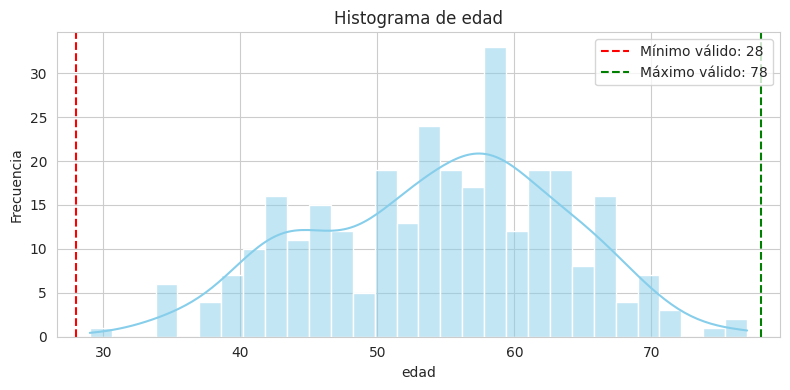

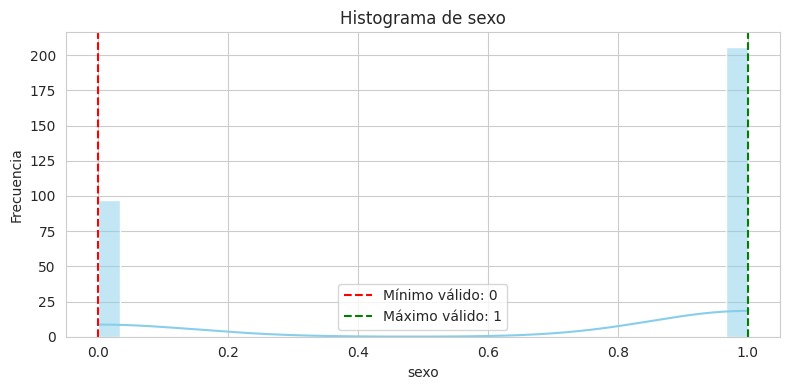

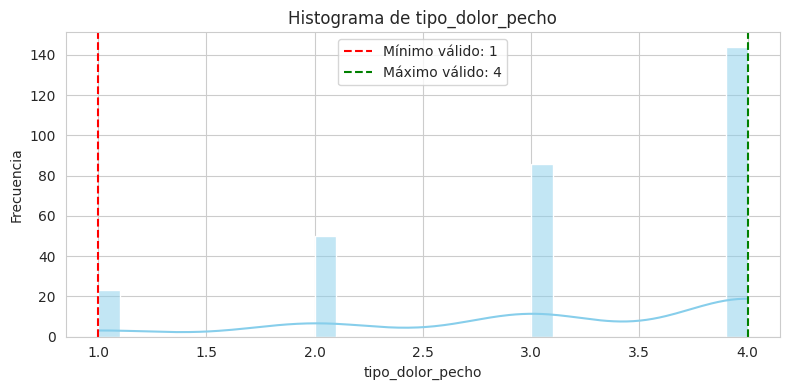

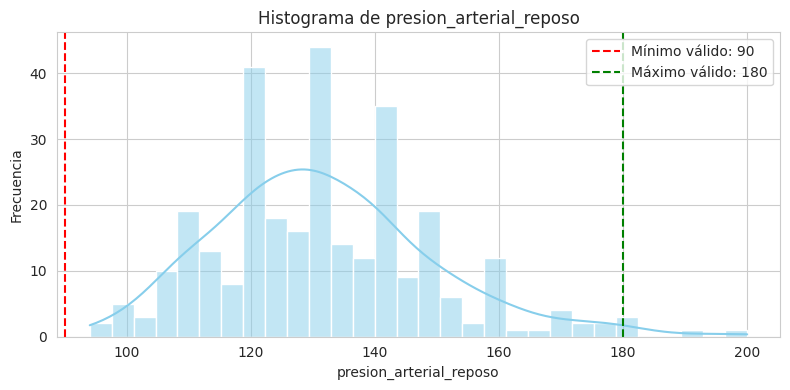

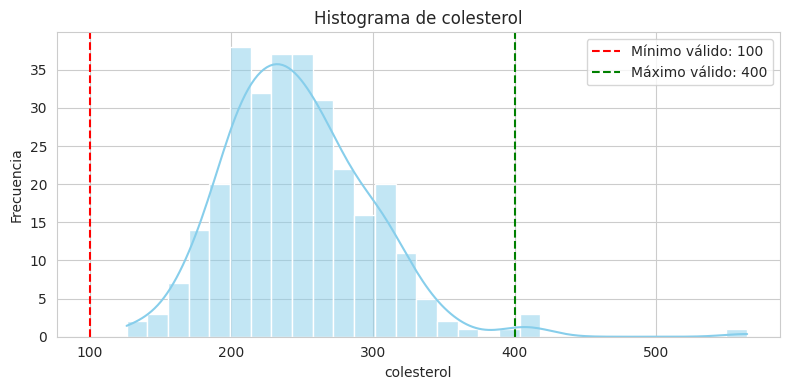

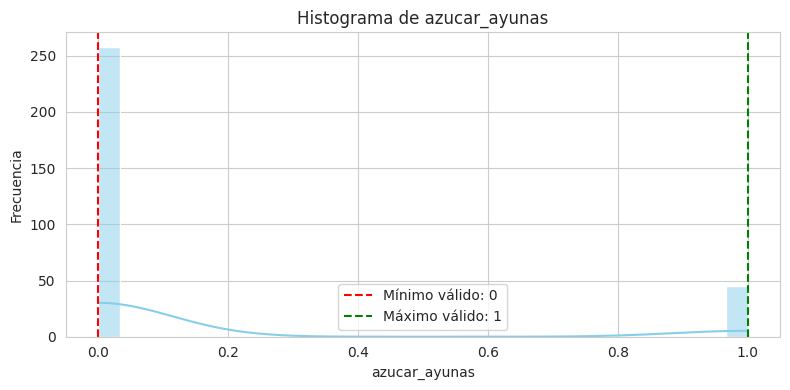

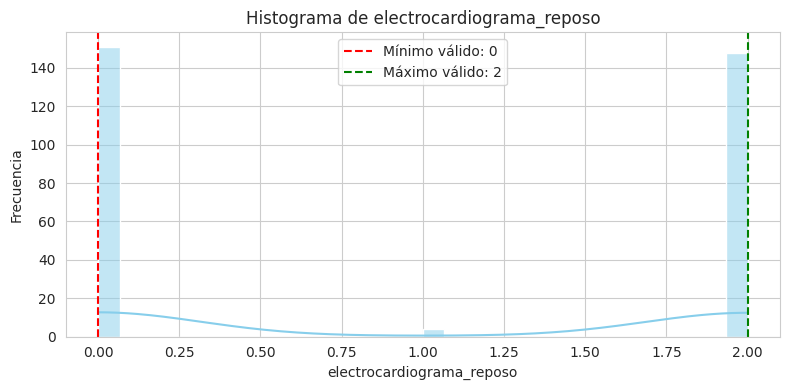

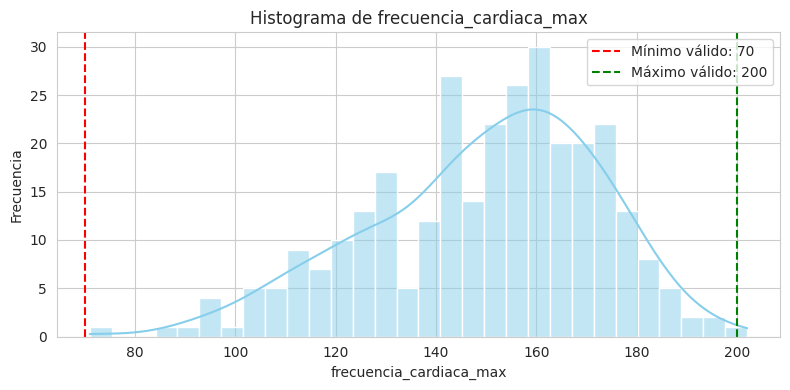

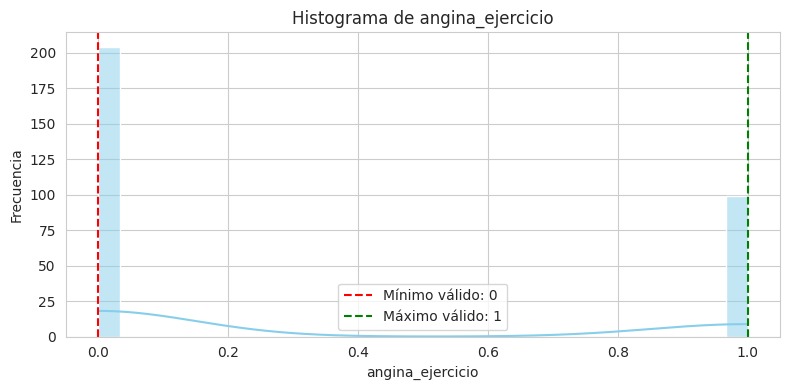

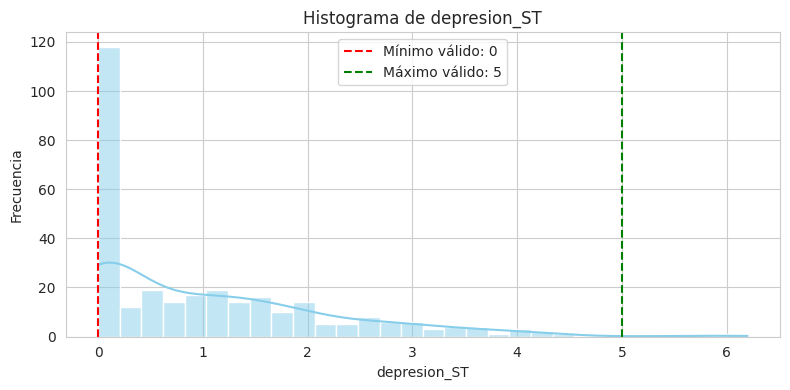

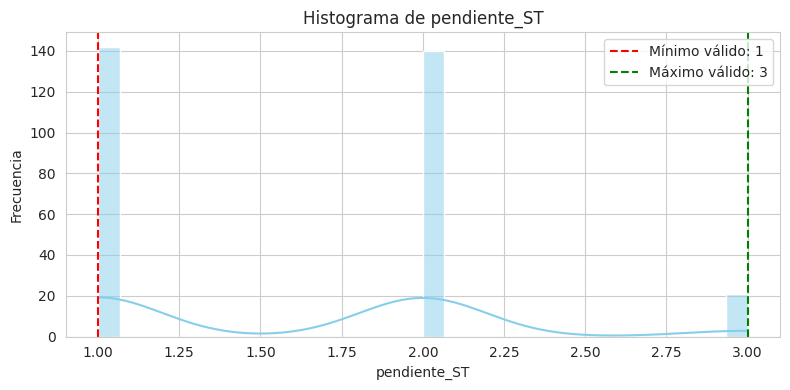

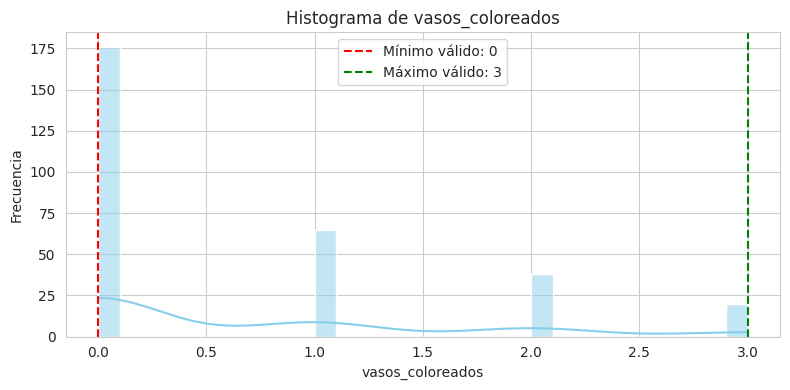

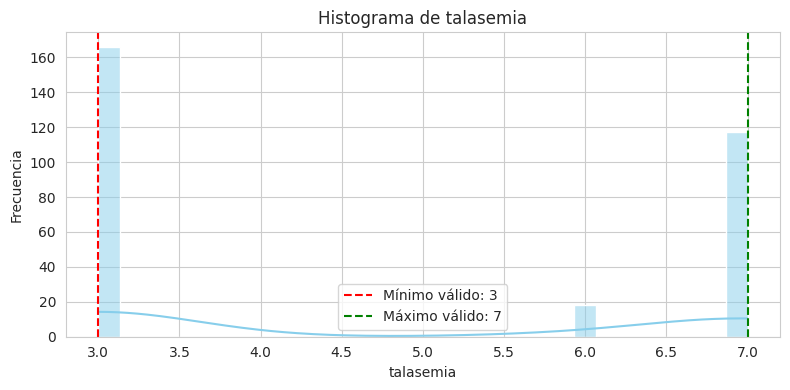

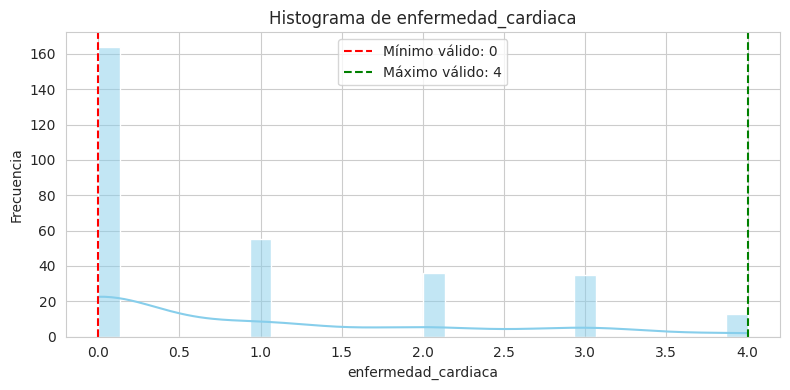

In [ ]:
# ========================
# Datos inconsistentes
# ========================

rangos_validos = {
    'edad': (28, 78),
    'sexo': (0, 1),
    'tipo_dolor_pecho': (1, 4),
    'presion_arterial_reposo': (90, 180),
    'colesterol': (100, 400),
    'azucar_ayunas': (0, 1),
    'electrocardiograma_reposo': (0, 2),
    'frecuencia_cardiaca_max': (70, 200),
    'angina_ejercicio': (0, 1),
    'depresion_ST': (0, 5),
    'pendiente_ST': (1, 3),
    'vasos_coloreados': (0, 3),
    'talasemia': (3, 7),
    'enfermedad_cardiaca': (0, 4)
}

# Graficar cada variable
for col, (min_val, max_val) in rangos_validos.items():
    plt.figure(figsize=(8, 4))
    sns.histplot(Cardiopatia_df[col], bins=30, kde=True, color='skyblue')
    plt.axvline(min_val, color='red', linestyle='--', label=f'Mínimo válido: {min_val}')
    plt.axvline(max_val, color='green', linestyle='--', label=f'Máximo válido: {max_val}')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()

Aunque se ha realisado un histograma a cada variable indiscriminadamente, hay que remarcar la existencia de 8 categoricos que han sido mostrados. Los cuales se aprecian por no tener datos continuos y por ende no dibujar la campana de GAUS.

      A continuación se describen los hallazgos observados en los histogramas de cada variable:

      - edad:
        - La variable edad presenta una distribución bimodal centrada, además de alta dispersión, concentrando los valores aproximadamente de 40 a 50 y 50 a 60. Permitiendo así, una posible segmentación.
      - sexo:
        - Variable categórica binaria con el doble de registros en el valor 0 respecto al valor 1.
      - tipo_dolor_pecho:
        - Variable categórica distribuida de forma descendente en frecuencia, desde el tipo 4 hasta el tipo 1.
      - presion_arterial_reposo:
        - Muestra una distribución sesgada positivamente, con una curva baja y ancha que indica alta dispersión. Los valores se concentran entre 120 y 140 mmHg.
      - colesterol:
        - Se observa una distribución centrada con curva alta y estrecha, lo que refleja baja dispersión y alta concentración de valores entre 200 y 250 mg/dL.
      - azucar_ayunas:
        - Variable categórica binaria con predominancia del valor 0; el valor 1 representa aproximadamente una quinta parte de los registros.
      - electrocardiograma_reposo:
        - Variable categórica con tres niveles. Los valores 0 y 2 presentan frecuencias similares, mientras que el valor 1 es poco frecuente.
      - frecuencia_cardiaca_max:
        - Presenta una distribución sesgada negativamente, con alta dispersión. La mayoría de los valores se agrupan alrededor de los 160 bpm.
      - angina_ejercicio:
        - Variable categórica binaria con mayor presencia del valor 0; el valor 1 aparece en aproximadamente la mitad de los casos.
      - depression_ST:
        - Muestra una distribución sesgada positivamente, con alta dispersión y una concentración marcada en el valor 0.
      - pendiente_ST:
        - Variable categórica con frecuencias similares en los valores 1 y 2, mientras que el valor 3 es poco frecuente.
      - vasos_coloreados:
        - Variable categórica con predominancia del valor 0, seguida por una distribución decreciente en los valores 1, 2 y 3.
      - talasemia:
        - Variable categórica con ausencia de registros en el valor 4, muy pocos en 5 y 6, y alta concentración en el valor 3, seguido del 7.
      - enfermedad_cardiaca:
        - Variable categórica con mayor presencia del valor 0. Los valores del 1 al 4 se distribuyen en orden descendente de frecuencia.


In [ ]:
# Aplicamos el filtro
for col, (min_val, max_val) in rangos_validos.items():
    Cardiopatia_df[col] = Cardiopatia_df[col].apply(lambda x: x if min_val <= x <= max_val else np.nan)

print(Cardiopatia_df.isna().sum())

edad                         0
sexo                         0
tipo_dolor_pecho             0
presion_arterial_reposo      2
colesterol                   4
azucar_ayunas                0
electrocardiograma_reposo    0
frecuencia_cardiaca_max      1
angina_ejercicio             0
depresion_ST                 2
pendiente_ST                 0
vasos_coloreados             4
talasemia                    2
enfermedad_cardiaca          0
dtype: int64


#### Valores faltantes (% por variable)

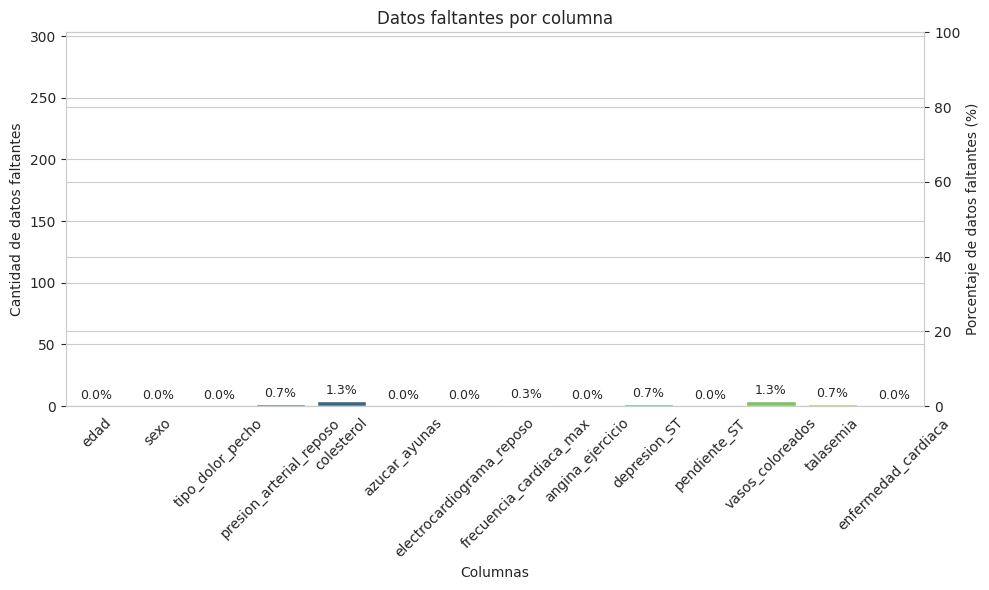

In [ ]:
# Gráfico de datos faltantes
fig, ax1 = plt.subplots(figsize=(10, 6))
missing_counts = Cardiopatia_df.isna().sum()
missing_percent = (missing_counts / Cardiopatia_df.shape[0]) * 100

# cantidades absolutas
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis', ax=ax1)
ax1.set_ylabel('Cantidad de datos faltantes')
ax1.set_xlabel('Columnas')
ax1.set_title('Datos faltantes por columna')
ax1.set_ylim(0, Cardiopatia_df.shape[0])
ax1.tick_params(axis='x', rotation=45)

# eje para porcentajes
ax2 = ax1.twinx()
ax2.set_ylabel('Porcentaje de datos faltantes (%)')
ax2.set_ylim(0, 100)

# etiquetas de porcentaje
for i, (count, percent) in enumerate(zip(missing_counts.values, missing_percent.values)):
    ax1.text(i, count + Cardiopatia_df.shape[0] * 0.01, f'{percent:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### Desbalanceos en variable objetivo

In [ ]:
# Ya que solo queremos saber si presenta cardiopatia o no, unificamos al resto mientras sean positivos.
Cardiopatia_df['enfermedad_cardiaca'] = (Cardiopatia_df['enfermedad_cardiaca'] > 0).astype(int)

In [ ]:
print("\n🎯 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (enfermedad_cardiaca):")
enfermedad_cardiaca_counts = Cardiopatia_df['enfermedad_cardiaca'].value_counts().sort_index()
enfermedad_cardiaca_props = enfermedad_cardiaca_counts / enfermedad_cardiaca_counts.sum()

print("Distribución absoluta:")
print(f"• Sin enfermedad cardiaca (0): {enfermedad_cardiaca_counts[0]} casos")
print(f"• Con enfermedad cardiaca (1): {enfermedad_cardiaca_counts[1]} casos")

print("\nDistribución porcentual:")
print(f"• Sin enfermedad cardiaca (0): {enfermedad_cardiaca_props[0]:.1%}")
print(f"• Con enfermedad cardiaca (1): {enfermedad_cardiaca_props[1]:.1%}")

# Verificar balance de clases
balance_ratio = min(enfermedad_cardiaca_counts) / max(enfermedad_cardiaca_counts)
print(f"• Ratio de balance: {balance_ratio:.2f}")

if balance_ratio < 0.3:
    print("⚠️ Dataset desbalanceado - considerar técnicas de balanceo")
elif balance_ratio < 0.6:
    print("⚡ Dataset moderadamente desbalanceado")
else:
    print("✅ Dataset razonablemente balanceado")


🎯 DISTRIBUCIÓN DE LA VARIABLE OBJETIVO (enfermedad_cardiaca):
Distribución absoluta:
• Sin enfermedad cardiaca (0): 164 casos
• Con enfermedad cardiaca (1): 139 casos

Distribución porcentual:
• Sin enfermedad cardiaca (0): 54.1%
• Con enfermedad cardiaca (1): 45.9%
• Ratio de balance: 0.85
✅ Dataset razonablemente balanceado


Con una distribución de clases de 54.1% vs 45.9% y un ratio de balance de 0.85, el dataset se considera razonablemente balanceado. Por lo que no es necesario aplicar técnicas de balanceo de clase, en su lugar es recomendable monitorear métricas como precisión, recall y F1-score por clase.

#### Boxplots

In [ ]:
def box_hist_plot(base_de_datos, v_objetivo, variable):
  """
  Visualiza la distribución de una variable numérica por clase de enfermedad cardíaca.

  Parámetros:
  - base_de_datos: DataFrame que contiene los datos.
  - v_objetivo: nombre de la variable objetivo (por ejemplo, 'enfermedad_cardiaca').
  - variable: nombre de la variable numérica a graficar.

  Salida:
  - Muestra dos gráficos por clase (sin/con enfermedad): boxplot y histograma con líneas de media, mediana, moda y desviación estándar.
  """

  plt.rcParams['axes.facecolor'] = '#D6F3FF'

  fig, axes = plt.subplots(2, 2, figsize=(12, 5.6))  # 2 filas, 2 columnas

  for col in base_de_datos[v_objetivo].unique():

    plot_dat = base_de_datos[base_de_datos[v_objetivo] == col][variable]
    if col == 0:
      S_C = "sin"
    else:
      S_C = "con"

    mean_value = plot_dat.mean()
    median_value = plot_dat.median()
    mode_value = plot_dat.mode().values[0]
    std_value = plot_dat.std()

    sns.boxplot(x=plot_dat, ax=axes[0][col], color='#45b1e8')

    axes[0][col].axvline(mean_value, color='b', linestyle='-', linewidth=2, label=f'Media: {mean_value:.2f}')
    axes[0][col].axvline(median_value, color='r', linestyle='-', linewidth=2, label=f'Mediana: {median_value:.2f}')
    axes[0][col].axvline(mode_value, color='m', linestyle='-', linewidth=2, label=f'Moda: {mode_value:.2f}')
    axes[0][col].axvline(mean_value + std_value, color='b', linestyle='dashed', linewidth=2, label=f'Std ±: {std_value:.2f}')
    axes[0][col].axvline(mean_value - std_value, color='b', linestyle='dashed')

    axes[0][col].set_title(f"Grafico de cajas de {variable} {S_C} enfermedad cardiaca")
    axes[0][col].set_xlabel("")
    axes[0][col].legend(loc='upper left')

    sns.histplot(plot_dat, kde=True, color='#45b1e8', ax=axes[1][col])

    axes[1][col].axvline(mean_value, color='b', linestyle='-', linewidth=2)
    axes[1][col].axvline(median_value, color='r', linestyle='-', linewidth=2)
    axes[1][col].axvline(mode_value, color='m', linestyle='-', linewidth=2)
    axes[1][col].axvline(mean_value + std_value, color='b', linestyle='dashed')
    axes[1][col].axvline(mean_value - std_value, color='b', linestyle='dashed')

    axes[1][col].set_xlabel(f"{variable} {S_C} enfermedad cardiaca")
    axes[1][col].set_ylabel("Densidad")

  plt.tight_layout()
  plt.show()


--------------------------------------------------------------------------------
                         📊 Visualizando variable: EDAD                          
--------------------------------------------------------------------------------


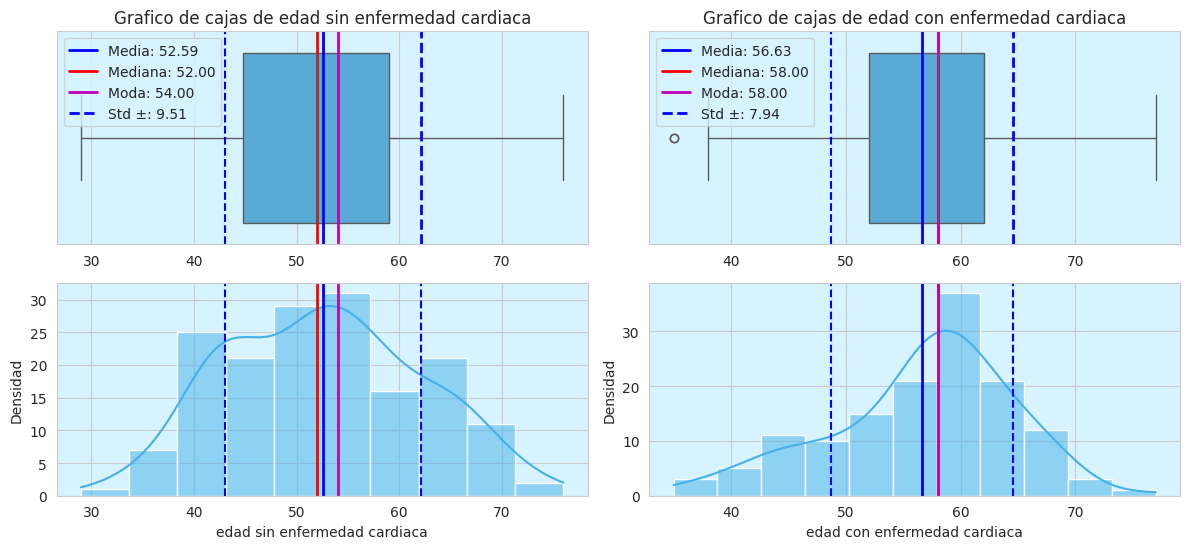

--------------------------------------------------------------------------------
                📊 Visualizando variable: PRESION_ARTERIAL_REPOSO                
--------------------------------------------------------------------------------


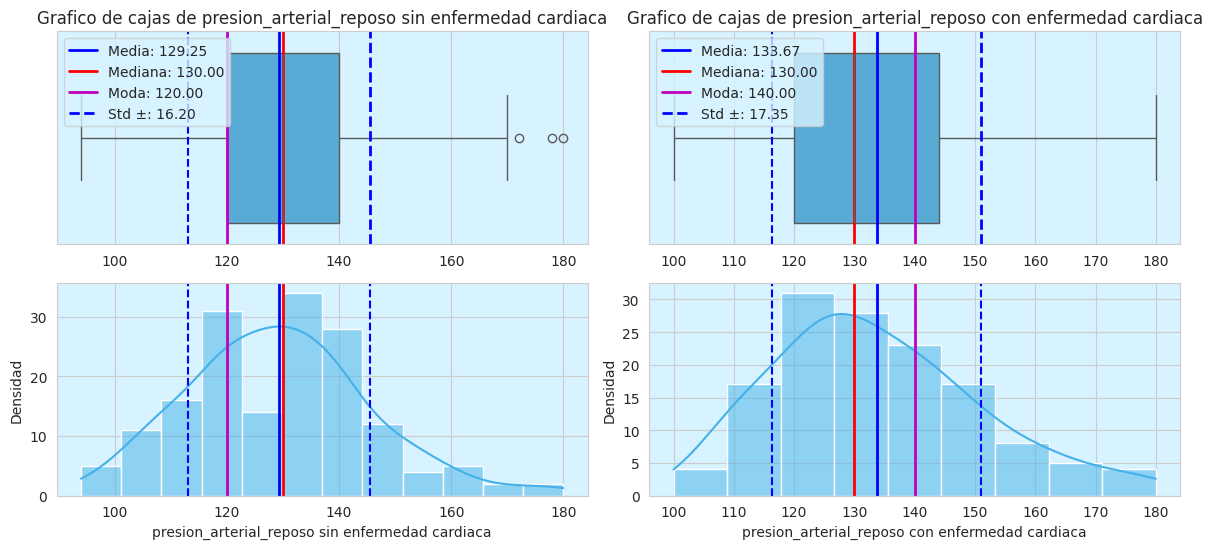

--------------------------------------------------------------------------------
                      📊 Visualizando variable: COLESTEROL                       
--------------------------------------------------------------------------------


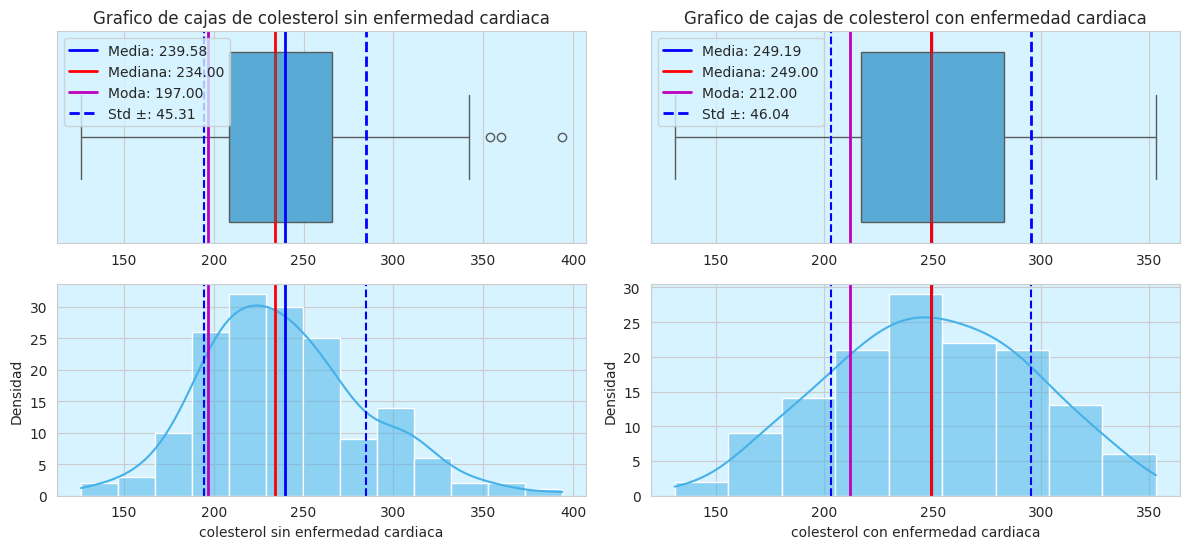

--------------------------------------------------------------------------------
                📊 Visualizando variable: FRECUENCIA_CARDIACA_MAX                
--------------------------------------------------------------------------------


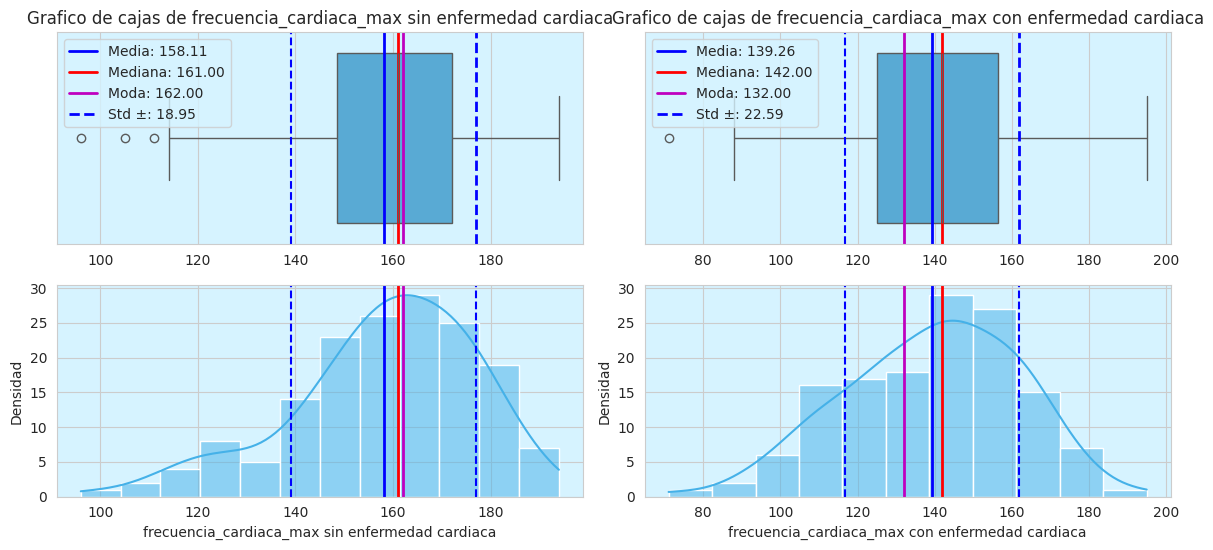

--------------------------------------------------------------------------------
                     📊 Visualizando variable: DEPRESION_ST                      
--------------------------------------------------------------------------------


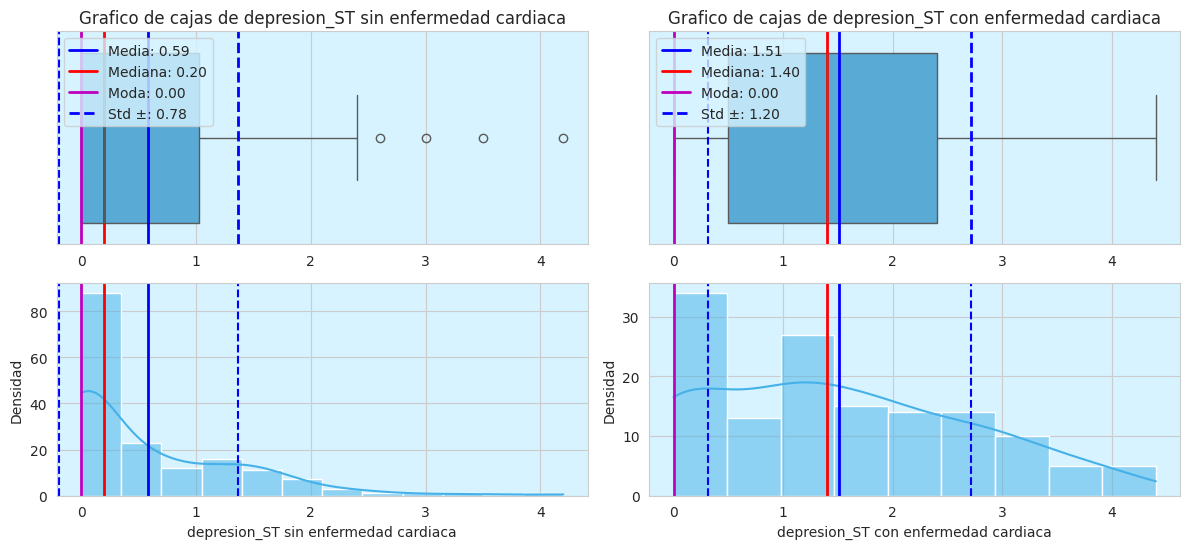

In [ ]:
# Seleccionar variables numéricas excepto enfermedad_cardiaca
variables = Cardiopatia_df[["edad", "presion_arterial_reposo", "colesterol", "frecuencia_cardiaca_max", "depresion_ST"]]

# Graficar cada variable
for var in variables:
  titulo = f"📊 Visualizando variable: {var.upper()}"
  print("-"*80 + "\n" + titulo.center(80, " ") + "\n" + "-"*80)

  box_hist_plot(Cardiopatia_df, v_objetivo= "enfermedad_cardiaca", variable= var)

#### Identificación de correlaciones bivariadas

Text(0.5, 1.0, 'Correlación de Pearson')

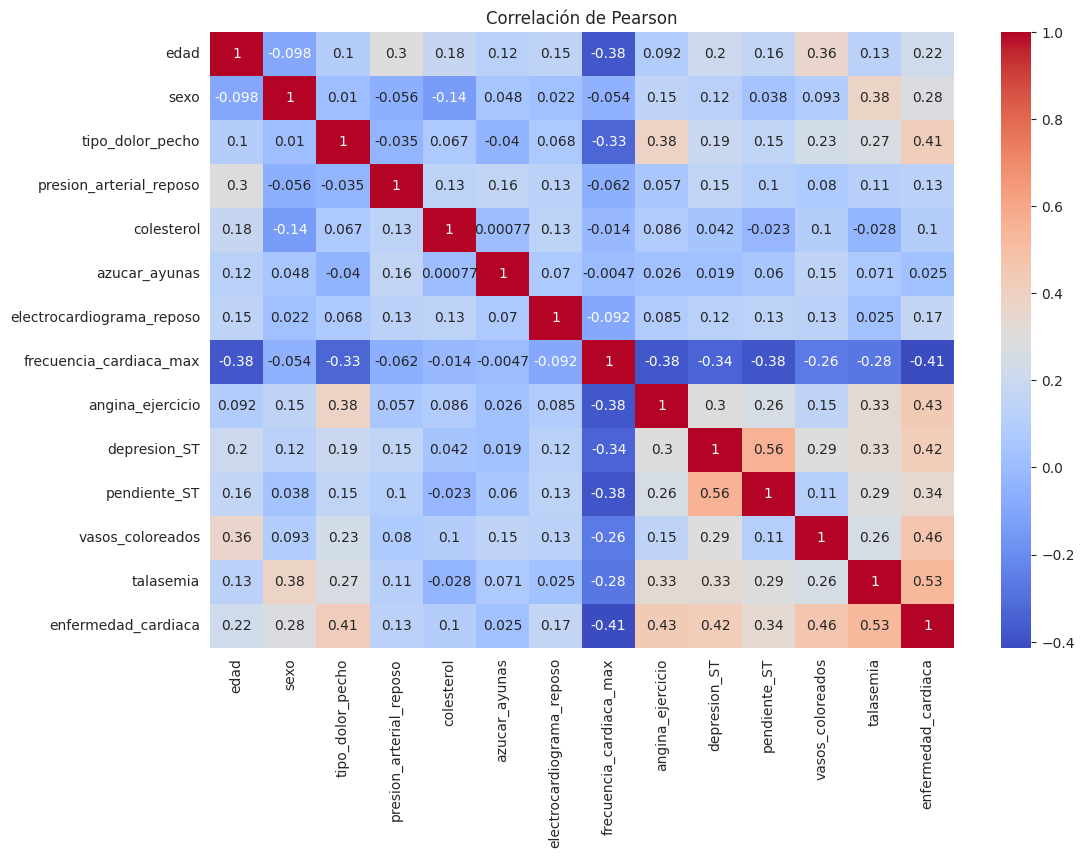

In [ ]:
# Correlación de Pearson entre variables numéricas
correlaciones = Cardiopatia_df.corr(method='pearson')
sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.title(f'Correlación de Pearson')

In [ ]:
# ========================
# Identificar correlaciones altas
# ========================
# Tomamos la parte superior de la matriz (sin diagonal)
high_corr_pairs = (
    correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ["Var1", "Var2", "Corr"]

# Ordenar por correlación descendente
high_corr_pairs = high_corr_pairs.sort_values(by="Corr", ascending=False)
high_corr_pairs = high_corr_pairs.reindex(high_corr_pairs["Corr"].abs().sort_values(ascending=False).index)

# Filtrar correlaciones
high_corr_pairs_filter = high_corr_pairs.loc[high_corr_pairs["Corr"].abs() > 0.3]

if not high_corr_pairs_filter.empty:
  print("\n  ORDENANDO CORRELACIONES ALTAS:")
  high_corr_pairs_filter.apply(
      lambda row: print(f"  • {row['Var1']} vs {row['Var2']}: {row['Corr']:.3f}"),
      axis=1
  )


  ORDENANDO CORRELACIONES ALTAS:
  • depresion_ST vs pendiente_ST: 0.557
  • talasemia vs enfermedad_cardiaca: 0.526
  • vasos_coloreados vs enfermedad_cardiaca: 0.460
  • angina_ejercicio vs enfermedad_cardiaca: 0.432
  • depresion_ST vs enfermedad_cardiaca: 0.421
  • tipo_dolor_pecho vs enfermedad_cardiaca: 0.414
  • frecuencia_cardiaca_max vs enfermedad_cardiaca: -0.414
  • tipo_dolor_pecho vs angina_ejercicio: 0.384
  • frecuencia_cardiaca_max vs pendiente_ST: -0.382
  • sexo vs talasemia: 0.381
  • edad vs frecuencia_cardiaca_max: -0.381
  • frecuencia_cardiaca_max vs angina_ejercicio: -0.376
  • edad vs vasos_coloreados: 0.363
  • pendiente_ST vs enfermedad_cardiaca: 0.339
  • frecuencia_cardiaca_max vs depresion_ST: -0.336
  • angina_ejercicio vs talasemia: 0.330
  • depresion_ST vs talasemia: 0.330
  • tipo_dolor_pecho vs frecuencia_cardiaca_max: -0.329


Aunque las correlaciones entre las variables independientes no son particularmente altas, lo que sugiere una baja probabilidad de multicolinealidad. De igual forma se recomienda aplicar VIF, ya que permite confirmar la estabilidad de los coeficientes y garantizar que no existen relaciones ocultas que puedan distorsionar la interpretación del modelo.

In [ ]:
# Filtrar correlaciones con la variable dependiente
dependiente = "enfermedad_cardiaca"
high_corr_dependiente = high_corr_pairs[
    (high_corr_pairs["Var1"] == dependiente) | (high_corr_pairs["Var2"] == dependiente)
]

if not high_corr_dependiente.empty:
    print("\n  CORRELACIONES CON LA VARIABLE DEPENDIENTE:")
    high_corr_dependiente.apply(
        lambda row: print(f"  • {row['Var1']} vs {row['Var2']}: {row['Corr']:.3f}"),
        axis=1
    )


  CORRELACIONES CON LA VARIABLE DEPENDIENTE:
  • talasemia vs enfermedad_cardiaca: 0.526
  • vasos_coloreados vs enfermedad_cardiaca: 0.460
  • angina_ejercicio vs enfermedad_cardiaca: 0.432
  • depresion_ST vs enfermedad_cardiaca: 0.421
  • tipo_dolor_pecho vs enfermedad_cardiaca: 0.414
  • frecuencia_cardiaca_max vs enfermedad_cardiaca: -0.414
  • pendiente_ST vs enfermedad_cardiaca: 0.339
  • sexo vs enfermedad_cardiaca: 0.277
  • edad vs enfermedad_cardiaca: 0.223
  • electrocardiograma_reposo vs enfermedad_cardiaca: 0.169
  • presion_arterial_reposo vs enfermedad_cardiaca: 0.131
  • colesterol vs enfermedad_cardiaca: 0.105
  • azucar_ayunas vs enfermedad_cardiaca: 0.025


Se considera la utilisacion de todas las variables ya que se evalua la aplicacion del VIF para detectar redundancias entre independientes. Con el objetivo de depurar el modelo y preservar la estabilidad de los coeficientes.

## Data Preparation (Preparación de los Datos)

### Limpieza de datos

#### Imputación de valores faltantes

##### Metodo MICE

###### 1. Preparar el DataFrame

In [ ]:
df = Cardiopatia_df.copy()
variables_con_nans = df.columns[df.isnull().any()]

###### 2. Inicializar imputación con medias

In [ ]:
# Las variables categoricas las remplasamos con la moda
for col in ["vasos_coloreados", "talasemia"]:
    df[col] = df[col].fillna(df[col].mode()[0])

# Detectar columnas con nulos
columnas_con_nulos = df.columns[df.isnull().any()]

# Imputar por mediana agrupada por sexo y edad
for col in columnas_con_nulos:
    if df[col].dtype in ["float64", "int64"]:  # Solo numéricas
        df[col] = df.groupby(["sexo", "edad"])[col].transform(
            lambda x: x.fillna(x.median())
        )

# Como medida preventiva imputamos con la mediana a aquellos que aun registren como nulos.
df = df.fillna(df.median())

      Usamos la mediana agrupada por sexo y edad, ademas de la moda para completar los valores nulos en una primera capa del metodo MICE.

      No usamos la media, para evitar que posibles outlaiers medicos sesguen nuestro modelo de regresion

###### 3. Iterar imputaciones por regresión

In [ ]:
n_iteraciones = 5

for iteracion in range(n_iteraciones):
    print(f"Iteración {iteracion + 1}")

    for col in variables_con_nans:
        df_temp = df.copy()

        # Separar variable objetivo y predictoras
        y = df_temp[col]
        X = df_temp.drop(columns=[col])

        # Solo usar filas donde y no es NaN
        mask = ~Cardiopatia_df[col].isnull()
        y_train = y[mask]
        X_train = X[mask]

        # Reentrenar modelo
        modelo = sm.OLS(y_train, X_train).fit()

        # Predecir valores faltantes
        X_pred = X[~mask]
        y_pred = modelo.predict(sm.add_constant(X_pred))

        # Imputar
        df.loc[~mask, col] = y_pred

Iteración 1
Iteración 2
Iteración 3
Iteración 4
Iteración 5


###### 4. Resultado final

In [ ]:
print("Imputación MICE manual completada.")
print(df.isnull().sum())  # Verifica que no queden NaNs

Imputación MICE manual completada.
edad                         0
sexo                         0
tipo_dolor_pecho             0
presion_arterial_reposo      0
colesterol                   0
azucar_ayunas                0
electrocardiograma_reposo    0
frecuencia_cardiaca_max      0
angina_ejercicio             0
depresion_ST                 0
pendiente_ST                 0
vasos_coloreados             0
talasemia                    0
enfermedad_cardiaca          0
dtype: int64


Ya que hemos usado el metodo MICE para la imputacion de datos categoricos, es esencial realisar un redondeo de los valores. Para asi, evitar inconsistencias.

In [ ]:
# Redondear valores imputados en variables categóricas
df["vasos_coloreados"] = df["vasos_coloreados"].round().astype(int)
df["talasemia"] = df["talasemia"].round().astype(int)

# verificar que los valores están dentro del rango
print("vasos_coloreados:", df["vasos_coloreados"].unique())
print("talasemia:", df["talasemia"].unique())

vasos_coloreados: [0 3 2 1]
talasemia: [6 3 7]


#### Tratamiento de outliers

In [ ]:
def eliminar_outliers_iqr(df, clase=None, contar=True, mostrar_limites=False):
    """
    Elimina outliers usando IQR. Si 'clase' existe y tiene más de una categoría, aplica por clase.

    Parámetros:
    - df: DataFrame original
    - clase: nombre de la columna objetivo (opcional)
    - contar: bool, si es True imprime cantidad de filas eliminadas
    - mostrar_limites: bool, si es True imprime los límites IQR por columna

    Retorna:
    - df_filtrado: DataFrame sin outliers
    """
    df_filtrado = pd.DataFrame()
    total_eliminados = 0

    aplicar_por_clase = (
        clase is not None and
        clase in df.columns and
        df[clase].nunique() > 1
    )

    if aplicar_por_clase:
        # Filtrado por clase
        for valor in df[clase].unique():
            df_clase = df[df[clase] == valor].copy()
            filas_originales = df_clase.shape[0]

            columnas_numericas = df_clase.select_dtypes(include=['int64', 'float64']).columns.tolist()
            columnas_numericas = [col for col in columnas_numericas if col != clase]

            for col in columnas_numericas:
                Q1 = df_clase[col].quantile(0.25)
                Q3 = df_clase[col].quantile(0.75)
                IQR = Q3 - Q1
                li = Q1 - 1.5 * IQR
                ls = Q3 + 1.5 * IQR

                if mostrar_limites:
                    print(f"{col} (Clase {valor}): IQR = {IQR:.2f}, Límites = [{li:.2f}, {ls:.2f}]")

                df_clase = df_clase[(df_clase[col] >= li) & (df_clase[col] <= ls)]

            eliminados = filas_originales - df_clase.shape[0]
            total_eliminados += eliminados

            if contar:
                print(f"Clase {valor}: {eliminados} filas eliminadas.")

            df_filtrado = pd.concat([df_filtrado, df_clase])

        df_filtrado = df_filtrado.sort_index()

    else:
        # Filtrado global
        df_filtrado = df.copy()
        filas_originales = df_filtrado.shape[0]

        columnas_numericas = df_filtrado.select_dtypes(include=['int64', 'float64']).columns.tolist()

        for col in columnas_numericas:
            Q1 = df_filtrado[col].quantile(0.25)
            Q3 = df_filtrado[col].quantile(0.75)
            IQR = Q3 - Q1
            li = Q1 - 1.5 * IQR
            ls = Q3 + 1.5 * IQR

            if mostrar_limites:
                print(f"{col}: IQR = {IQR:.2f}, Límites = [{li:.2f}, {ls:.2f}]")

            df_filtrado = df_filtrado[(df_filtrado[col] >= li) & (df_filtrado[col] <= ls)]

        total_eliminados = filas_originales - df_filtrado.shape[0]
        if contar:
            print(f"Se eliminaron {total_eliminados} filas por contener valores atípicos.")

    return df_filtrado

In [ ]:
def plot_transform(df, transformed_df, variable):
  """
  Compara visualmente una variable antes y después de su transformación.

  Parámetros:
  - df: DataFrame original antes de la transformación.
  - transformed_df: DataFrame con la variable ya transformada.
  - variable: nombre de la variable numérica a comparar.

  Salida:
  - Muestra cuatro gráficos: boxplot y histograma (con KDE) para la versión original y transformada de la variable.
  """

  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

  sns.boxplot(x=df[variable], ax=axes[0, 0], color='#00308F')
  axes[0, 0].set_title(f"{variable} original")

  sns.boxplot(x=transformed_df[variable], ax=axes[0, 1], color='#7CB9E8')
  axes[0, 1].set_title(f"{variable} transformada")

  sns.histplot(df[variable], ax=axes[1, 0], kde=True, color='#00308F')
  axes[1, 0].set_title(f"Distribución de {variable} original")

  sns.histplot(transformed_df[variable], ax=axes[1, 1], kde=True, color='#7CB9E8')
  axes[1, 1].set_title(f"Distribución de {variable} transformada")

  plt.tight_layout()
  plt.show()

In [ ]:
v = ["edad", "presion_arterial_reposo", "colesterol", "frecuencia_cardiaca_max", "depresion_ST", "enfermedad_cardiaca"]

# Lista de columnas categóricas (todas excepto las numéricas en v)
categoricas = [col for col in df.columns if col not in v]

# Convertir a tipo categórico
df[categoricas] = df[categoricas].astype("category")

# Aplicamos funcion para quitar outlaiers
df_limpio = eliminar_outliers_iqr(df, clase="enfermedad_cardiaca", contar=True, mostrar_limites=True)

edad (Clase 0): IQR = 14.25, Límites = [23.38, 80.38]
presion_arterial_reposo (Clase 0): IQR = 20.00, Límites = [90.00, 170.00]
colesterol (Clase 0): IQR = 56.00, Límites = [125.00, 349.00]
frecuencia_cardiaca_max (Clase 0): IQR = 23.75, Límites = [112.62, 207.62]
depresion_ST (Clase 0): IQR = 1.05, Límites = [-1.58, 2.62]
Clase 0: 11 filas eliminadas.
edad (Clase 1): IQR = 10.00, Límites = [37.00, 77.00]
presion_arterial_reposo (Clase 1): IQR = 25.00, Límites = [82.50, 182.50]
colesterol (Clase 1): IQR = 65.00, Límites = [120.50, 380.50]
frecuencia_cardiaca_max (Clase 1): IQR = 32.00, Límites = [77.00, 205.00]
depresion_ST (Clase 1): IQR = 1.93, Límites = [-2.31, 5.39]
Clase 1: 3 filas eliminadas.


--------------------------------------------------------------------------------
                         EDAD - Sin enfermedad cardíaca                         
--------------------------------------------------------------------------------


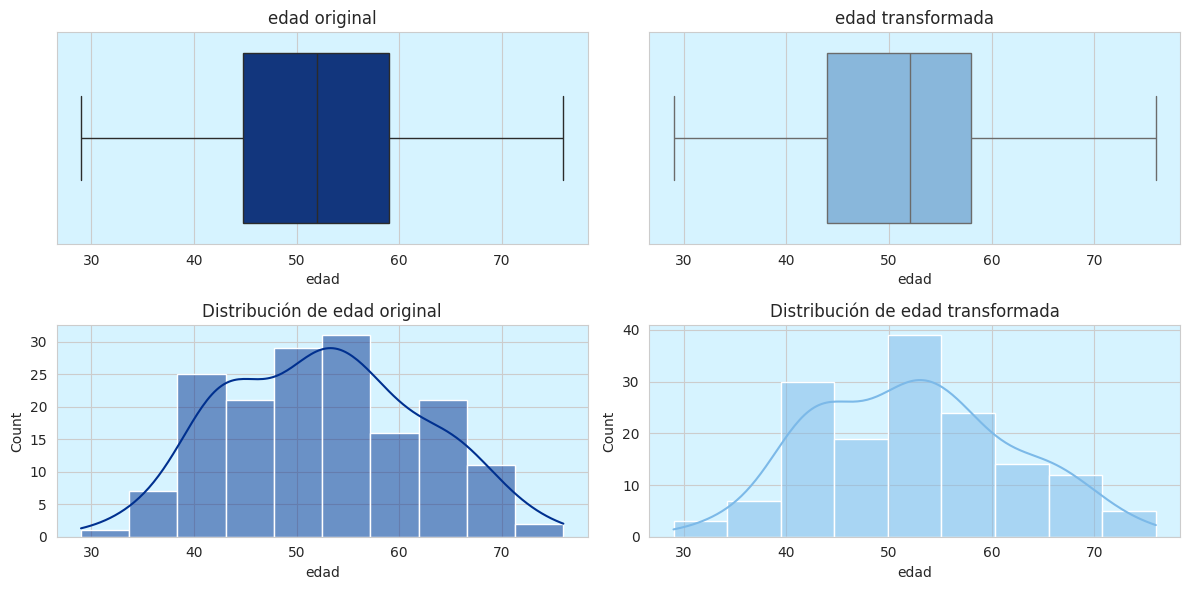

--------------------------------------------------------------------------------
                         EDAD - Con enfermedad cardíaca                         
--------------------------------------------------------------------------------


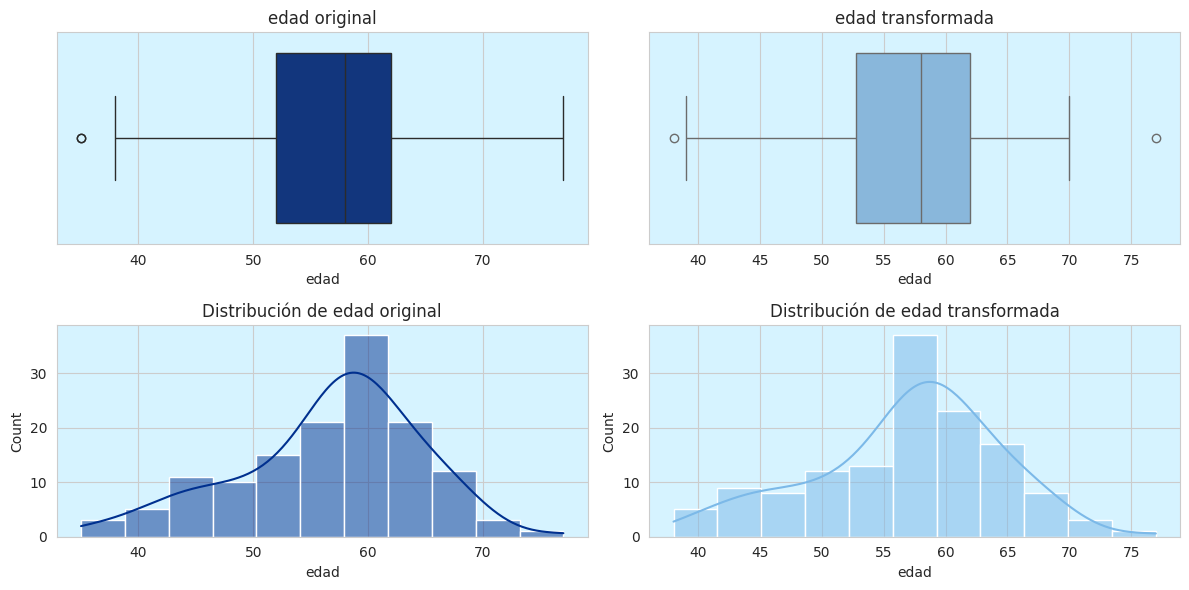

--------------------------------------------------------------------------------
               PRESION_ARTERIAL_REPOSO - Sin enfermedad cardíaca                
--------------------------------------------------------------------------------


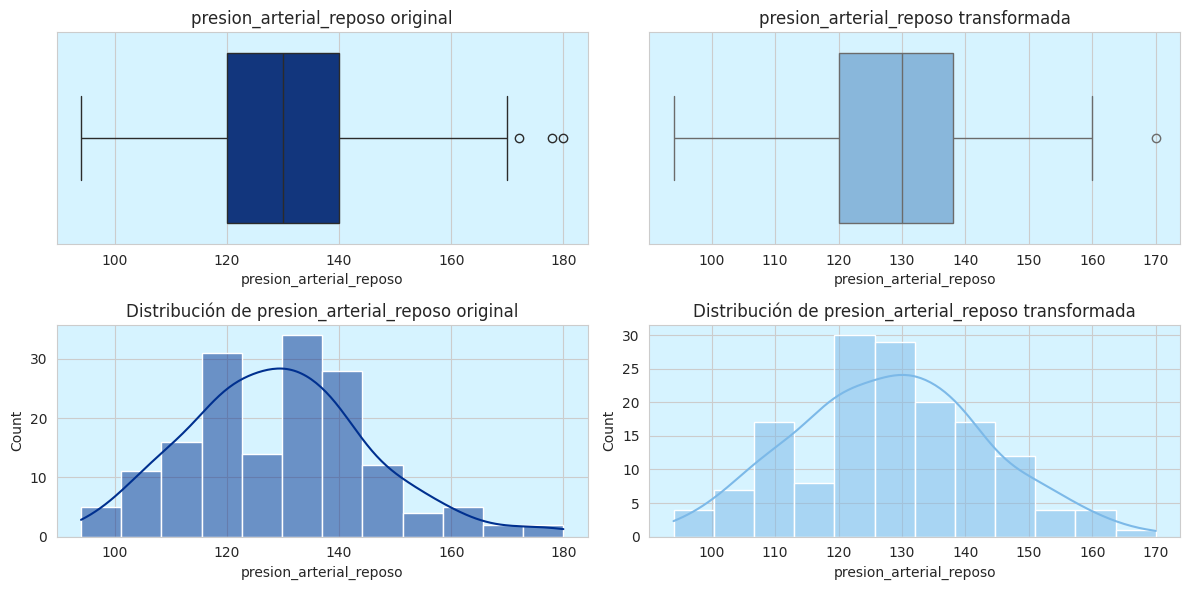

--------------------------------------------------------------------------------
               PRESION_ARTERIAL_REPOSO - Con enfermedad cardíaca                
--------------------------------------------------------------------------------


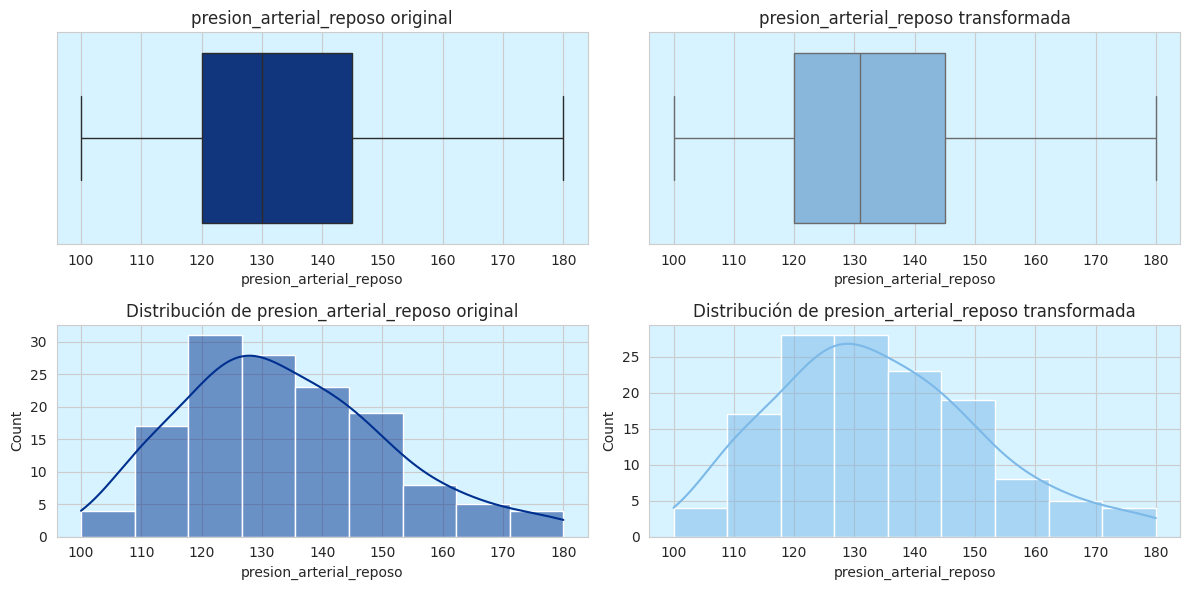

--------------------------------------------------------------------------------
                      COLESTEROL - Sin enfermedad cardíaca                      
--------------------------------------------------------------------------------


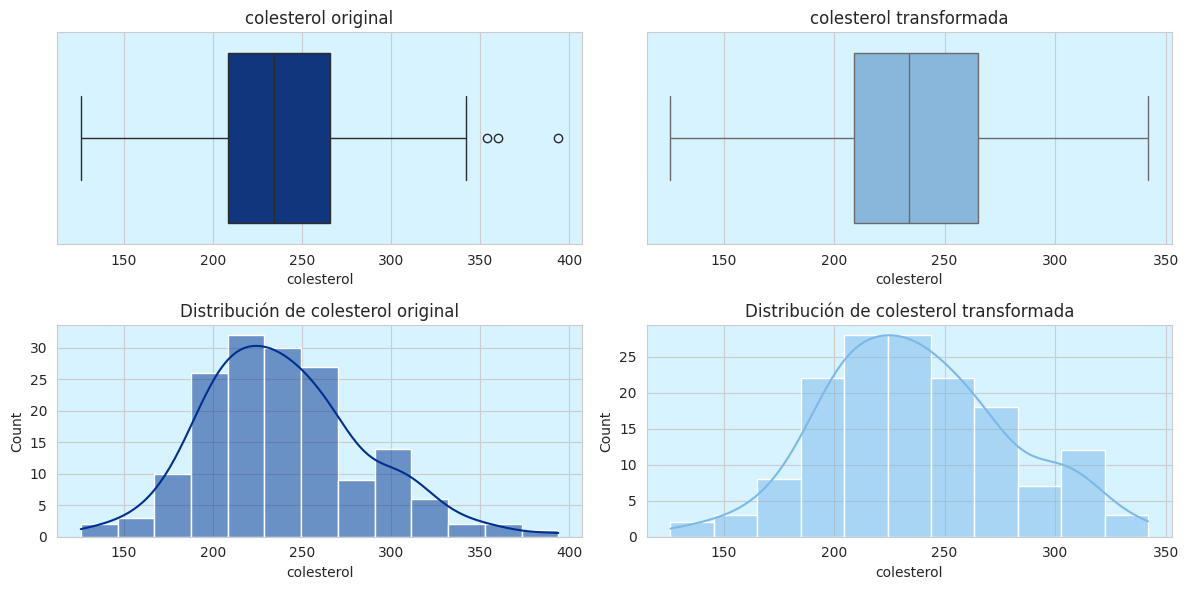

--------------------------------------------------------------------------------
                      COLESTEROL - Con enfermedad cardíaca                      
--------------------------------------------------------------------------------


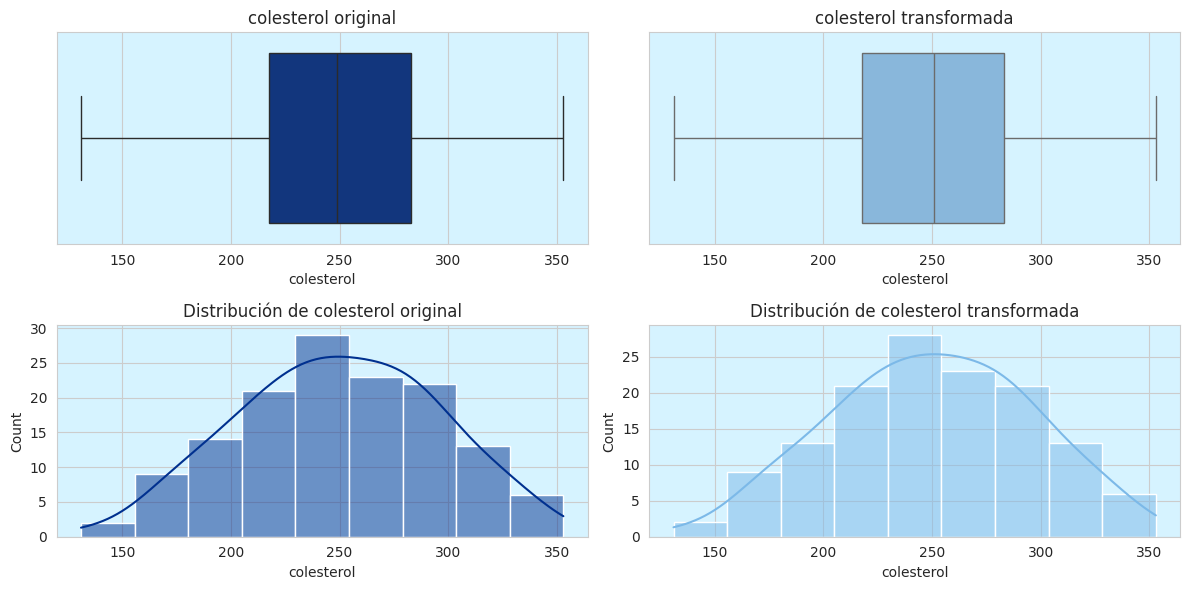

--------------------------------------------------------------------------------
               FRECUENCIA_CARDIACA_MAX - Sin enfermedad cardíaca                
--------------------------------------------------------------------------------


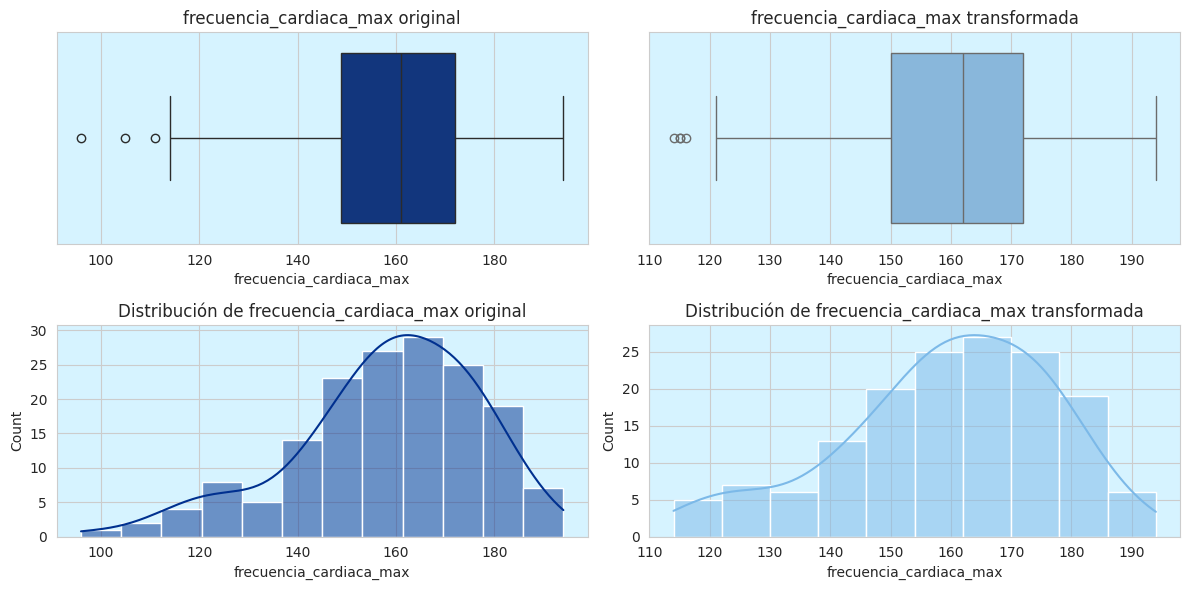

--------------------------------------------------------------------------------
               FRECUENCIA_CARDIACA_MAX - Con enfermedad cardíaca                
--------------------------------------------------------------------------------


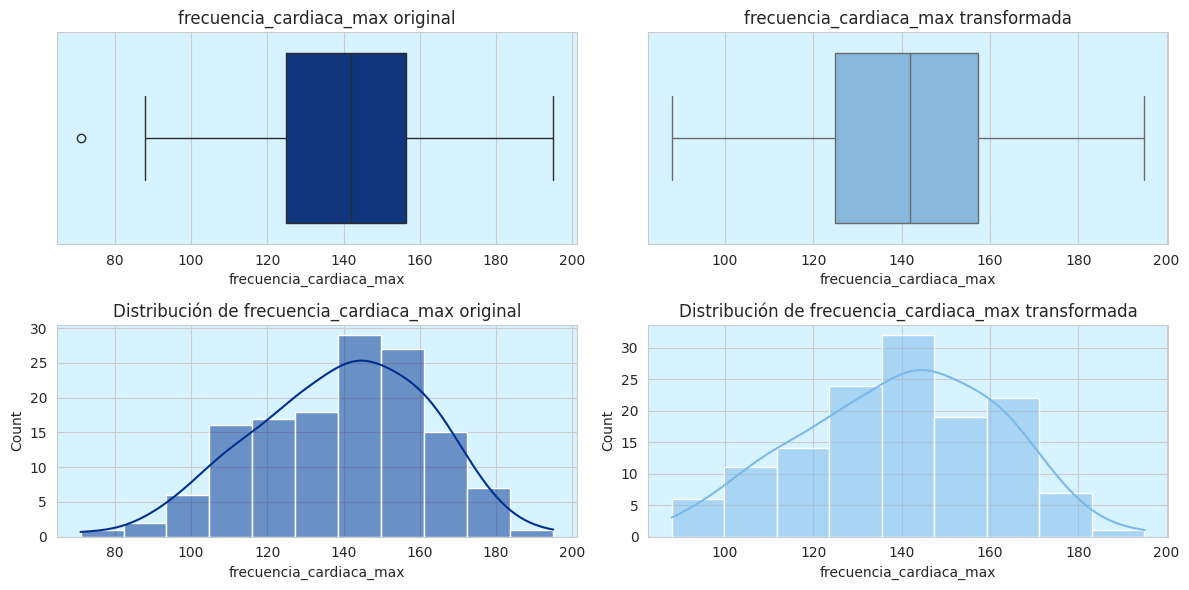

--------------------------------------------------------------------------------
                     DEPRESION_ST - Sin enfermedad cardíaca                     
--------------------------------------------------------------------------------


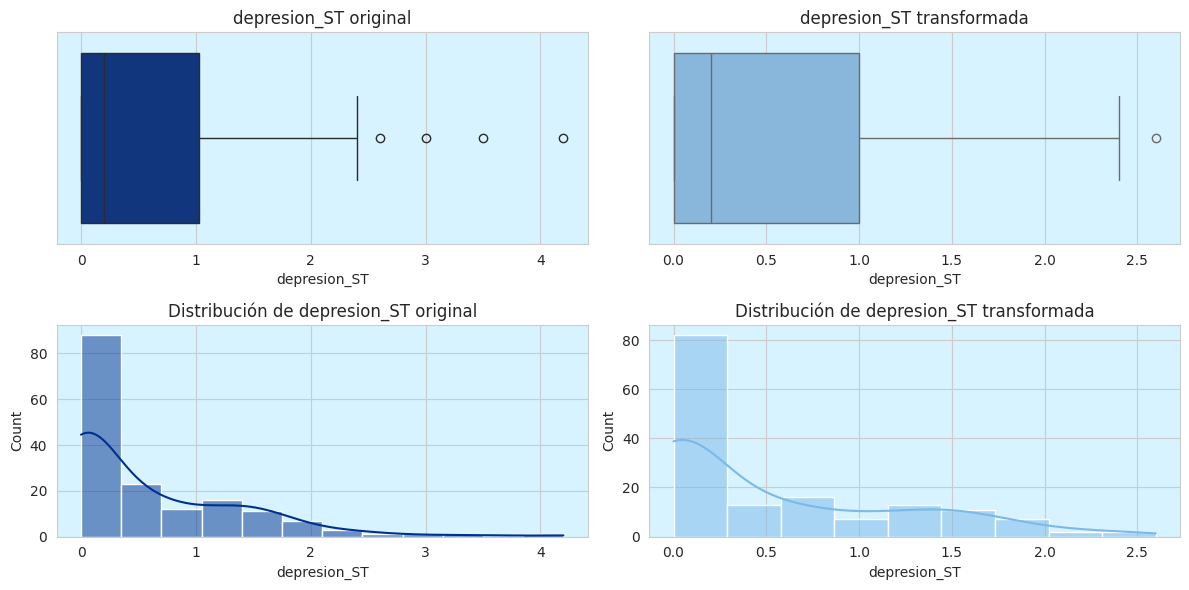

--------------------------------------------------------------------------------
                     DEPRESION_ST - Con enfermedad cardíaca                     
--------------------------------------------------------------------------------


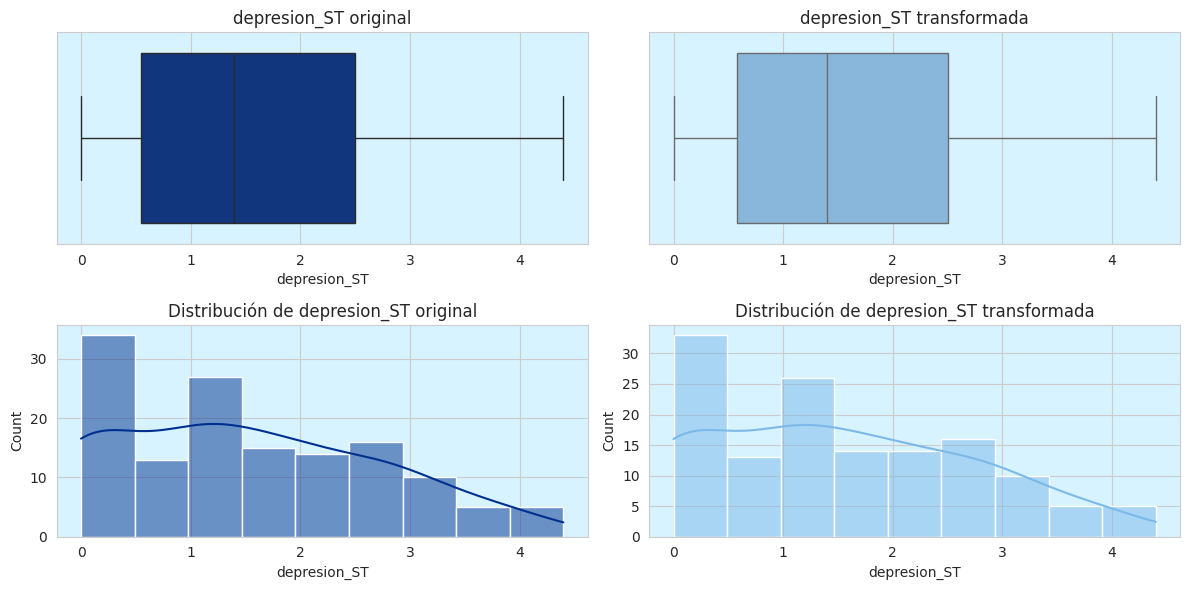

In [ ]:
for variable in v[:-1]:
    for clase in [0, 1]:
        titulo = f"{variable.upper()} - {'Sin' if clase == 0 else 'Con'} enfermedad cardíaca"
        df_filtrado_1 = df[df["enfermedad_cardiaca"] == clase]
        df_filtrado_2 = df_limpio[df_limpio["enfermedad_cardiaca"] == clase]

        print("-"*80 + "\n" + titulo.center(80, " ") + "\n" + "-"*80)
        plot_transform(df_filtrado_1, df_filtrado_2, variable=variable)

In [ ]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   edad                       289 non-null    int64   
 1   sexo                       289 non-null    category
 2   tipo_dolor_pecho           289 non-null    category
 3   presion_arterial_reposo    289 non-null    float64 
 4   colesterol                 289 non-null    float64 
 5   azucar_ayunas              289 non-null    category
 6   electrocardiograma_reposo  289 non-null    category
 7   frecuencia_cardiaca_max    289 non-null    float64 
 8   angina_ejercicio           289 non-null    category
 9   depresion_ST               289 non-null    float64 
 10  pendiente_ST               289 non-null    category
 11  vasos_coloreados           289 non-null    category
 12  talasemia                  289 non-null    category
 13  enfermedad_cardiaca        289 non-null 

#### Eliminación de duplicados

In [ ]:
df_limpio[df_limpio.duplicated(keep=False)]

,edad,sexo,tipo_dolor_pecho,presion_arterial_reposo,colesterol,azucar_ayunas,electrocardiograma_reposo,frecuencia_cardiaca_max,angina_ejercicio,depresion_ST,pendiente_ST,vasos_coloreados,talasemia,enfermedad_cardiaca


No hay duplicados.

### Transformación de variables

#### Codificación de variables categóricas

Ya que la base de datos presenta a las variables categoricas con "Ordinal Encoding" aplicado. Procedemos a revertir la codificacion, unicamente en las variables categoricas Nominales. Para asi, poder aplicar "One-Hot Encoding".

In [ ]:
a_entero = ["sexo", "presion_arterial_reposo", "colesterol", "azucar_ayunas",
            "frecuencia_cardiaca_max", "angina_ejercicio", "vasos_coloreados"]

# Convertir a tipo entero
df_limpio[a_entero] = df_limpio[a_entero].astype("int")

##### One-Hot Encoding

In [ ]:
# Revertir codificación
df_limpio["tipo_dolor_pecho"] = df_limpio["tipo_dolor_pecho"].map(
    {1: "asintomático", 2: "angina típica", 3: "angina atípica", 4: "dolor no anginoso"})

df_limpio["electrocardiograma_reposo"] = df_limpio["electrocardiograma_reposo"].map(
    {0: "Normal", 1: "Anomalías ST-T", 2: "Hipertrofia ventricular izquierda"})

df_limpio["pendiente_ST"] = df_limpio["pendiente_ST"].map(
    {1: "ascendente", 2: "plano", 3: "descendente"})

df_limpio["talasemia"] = df_limpio["talasemia"].map(
    {3: "normal", 6: "defecto fijo", 7: "defecto reversible"})

# Aplicar One-Hot Encoding
df_limpio = pd.get_dummies(df_limpio, columns=["tipo_dolor_pecho"], drop_first=True)
df_limpio = pd.get_dummies(df_limpio, columns=["electrocardiograma_reposo"], drop_first=True)
df_limpio = pd.get_dummies(df_limpio, columns=["pendiente_ST"], drop_first=True)
df_limpio = pd.get_dummies(df_limpio, columns=["talasemia"], drop_first=True)

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, 0 to 302
Data columns (total 19 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   edad                                                         289 non-null    int64  
 1   sexo                                                         289 non-null    int64  
 2   presion_arterial_reposo                                      289 non-null    int64  
 3   colesterol                                                   289 non-null    int64  
 4   azucar_ayunas                                                289 non-null    int64  
 5   frecuencia_cardiaca_max                                      289 non-null    int64  
 6   angina_ejercicio                                             289 non-null    int64  
 7   depresion_ST                                                 289 non-null    float64


convertimos los booleanos obtenidos en enteros, para evitar futuros errores.

In [ ]:
for col in df_limpio.columns:
    if df_limpio[col].dtype == 'bool':
        df_limpio[col] = df_limpio[col].astype(int)

### División del dataset

#### Train/Test split (70-30)

In [ ]:
# 3.1 División estratificada
Xc = df_limpio.drop(columns=["enfermedad_cardiaca"])
yc = df_limpio["enfermedad_cardiaca"]

print(" DIVISIÓN DE DATOS:")
Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    Xc, yc, test_size=0.3, stratify=yc, random_state=42)
print(f"  • Entrenamiento: {Xc_tr.shape[0]} observaciones")
print(f"  • Prueba: {Xc_te.shape[0]} observaciones")
print(f"  • Proporción mantenida en train: {yc_tr.mean():.3f}")
print(f"  • Proporción mantenida en test: {yc_te.mean():.3f}")

 DIVISIÓN DE DATOS:
  • Entrenamiento: 202 observaciones
  • Prueba: 87 observaciones
  • Proporción mantenida en train: 0.470
  • Proporción mantenida en test: 0.471


Se utilizó una división 70-30 para garantizar una evaluación robusta del modelo, preservando suficiente información para el entrenamiento sin comprometer la capacidad de validación. Esta proporción permite detectar sobreajuste y comparar el rendimiento entre modelos de forma confiable

Train Test Split devuelve respectivamente las variables de "x" e "y" divididos en entrenamiento (_tr) y testeo o prueba (_te).

#### Normalización/Estandarización de variables numéricas

In [ ]:
# Escalado (solo en entrenamiento para evitar data leakage)
print(f"\n ESCALADO ESTÁNDAR:")
scaler_c = StandardScaler().fit(Xc_tr)
Xc_tr_sc = scaler_c.transform(Xc_tr)
Xc_te_sc = scaler_c.transform(Xc_te)

print("  Scaler ajustado solo con datos de entrenamiento ")
print(f"  Media antes del escalado (train): {Xc_tr.mean().mean():.3f}")
print(f"  Media después del escalado (train): {Xc_tr_sc.mean():.3f}")

# Volviendo DataFrame
Xc_tr_sc = pd.DataFrame(Xc_tr_sc, columns= Xc.columns)
Xc_te_sc = pd.DataFrame(Xc_te_sc, columns= Xc.columns)


 ESCALADO ESTÁNDAR:
  Scaler ajustado solo con datos de entrenamiento 
  Media antes del escalado (train): 32.495
  Media después del escalado (train): -0.000


#### Calculo del VIF

In [ ]:
# 3.3 Análisis de multicolinealidad con VIF
print(f"\n ANÁLISIS DE MULTICOLINEALIDAD (VIF):")
print("VIF > 10 indica multicolinealidad severa, VIF > 5 indica multicolinealidad moderada")


 ANÁLISIS DE MULTICOLINEALIDAD (VIF):
VIF > 10 indica multicolinealidad severa, VIF > 5 indica multicolinealidad moderada


In [ ]:
# Calcular VIF para variables clave (usar datos escalados)

key_vars = [col for col in Xc.columns if col != "enfermedad_cardiaca"]

Xc_tr_key = Xc_tr_sc[key_vars]
vif_data = pd.DataFrame()
vif_data["Variable"] = key_vars
vif_data["VIF"] = [variance_inflation_factor(Xc_tr_key.values, i)
                   for i in range(len(key_vars))]
vif_data = vif_data.sort_values('VIF', ascending=False)
print(vif_data)


# Interpretar VIF
print("\n📋 INTERPRETACIÓN VIF:")
for _, row in vif_data.iterrows():
    var, vif = row['Variable'], row['VIF']
    if vif > 10:
        status = " SEVERA"
    elif vif > 5:
        status = "MODERADA"
    else:
        status = " ACEPTABLE"
    print(f"  • {var}: VIF = {vif:.2f} - {status}")

                                             Variable       VIF
11                 tipo_dolor_pecho_dolor no anginoso  4.047465
10                    tipo_dolor_pecho_angina atípica  3.306511
9                      tipo_dolor_pecho_angina típica  2.755328
7                                        depresion_ST  1.972522
5                             frecuencia_cardiaca_max  1.736134
14                                 pendiente_ST_plano  1.723842
17                       talasemia_defecto reversible  1.707405
6                                    angina_ejercicio  1.550768
0                                                edad  1.498630
15                           pendiente_ST_descendente  1.428658
1                                                sexo  1.388565
8                                    vasos_coloreados  1.382067
16                             talasemia_defecto fijo  1.341311
2                             presion_arterial_reposo  1.284933
12           electrocardiograma_reposo_A

## Modeling (Modelado)

### STEP AIC

In [ ]:
######################################################################################
#################### Criterio de Información de Akaike ###############################
######################################################################################
# Función para realizar step AIC
def step_aic(X, y):
    """
    Realiza step AIC para seleccionar el mejor conjunto de variables.
    """
    remaining = set(X.columns)#CONJUNTO de variables candidatas que aún  no han sido selecionadas
    selected = []#lista de las variables ya seleccionadas para el modelo
    best_score = np.inf#vairbale para almacernar el menor valor de AIC encontrado hasta ahora. Se inicia con infinito (np.onf) para
    #asegurar que cualquier AIC sea menor que el inicial

    while remaining:#mientras haya variables candidatas disponibles, el bucle continua
        scores_with_candidates = []#almacenar el AIC y la variable candidata en una lista
        for candidate in remaining:##itera sobre cada variable candidata
            formula = " + ".join(selected + [candidate])##crea una formula con las variables seleccionadas mas la candidata actua
    ###############construye un modelo de regresion logistica con las variables seleccionadas y la candidata
            model = sm.Logit(y, sm.add_constant(X[selected + [candidate]]))
    #######################################################################################
            result = model.fit(disp=0)#ajusta el modelo sin mostrar el mensaje de salidad disp=0
            score = result.aic#calcula el aic del modelo ajustado

            scores_with_candidates.append((score, candidate))#almacenha el aic y la variable candidata

        # Seleccionar la variable con el menor AIC

        scores_with_candidates.sort(key=lambda x: x[0])#ordena las variables candidatas por su AIC por el primer valor de la tupla
        best_new_score, best_candidate = scores_with_candidates[0]#extrae el menor aic y la variable candidata

        if best_new_score < best_score:#actualizar la variable seleccionada
            remaining.remove(best_candidate)#elimina la variable seleccionada del conjunto de candidatas
            selected.append(best_candidate)#agrega la variable del conjunto de variables selccionadas
            best_score = best_new_score#actualizar el mejor AIC
        else:
            break#si el aic no mejora el bucle termina

    return selected#retorna la lista de variables seleccionadas que minimizan el AIC


In [ ]:
# Agrega la constante (intercepto)
X_train_const = sm.add_constant(Xc_tr)

# Aplicar step AIC
selected_features = step_aic(Xc_tr, yc_tr)
print("\nVariables seleccionadas por Step AIC:")
print(selected_features)

# Reducir el dataset a las variables seleccionadas
X_train_AIC = Xc_tr_sc[selected_features]
X_test_AIC = Xc_te_sc[selected_features]



Variables seleccionadas por Step AIC:
['tipo_dolor_pecho_dolor no anginoso', 'talasemia_defecto reversible', 'vasos_coloreados', 'pendiente_ST_plano', 'angina_ejercicio', 'sexo', 'colesterol', 'depresion_ST']


### Boruta

#### Grid Search

In [ ]:
# Definir el espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Modelo base
rf_base = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(Xc_tr, yc_tr)

# Mejor modelo
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, 

In [ ]:
best_rf

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=7,
                       min_samples_leaf=4, n_estimators=200, n_jobs=-1,
                       random_state=42)

#### Aplicar Boruta

In [ ]:
# Inicializar Boruta
boruta_selector = BorutaPy(estimator=best_rf, n_estimators='auto', verbose=2, random_state=42)

# Ajustar al dataset
boruta_selector.fit(Xc_tr.values, yc_tr.values)


# Variables aceptadas por Boruta
selected_features = Xc_tr.columns[boruta_selector.support_].tolist()
print("✅ Variables seleccionadas por Boruta:")
print(selected_features)

# Variables rechazadas
rejected_features = Xc_tr.columns[~boruta_selector.support_].tolist()
print("\n❌ Variables descartadas por Boruta:")
print(rejected_features)

# Convertimos a DataFrame
X_train_Boruta = Xc_tr_sc[selected_features]
X_test_Boruta = Xc_te_sc[selected_features]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	3
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	8
Iteration:

### Modelos

In [ ]:
def modelar_GS_reg_log(X_train, txt = "BASE"):
  # Modelo base
  logreg = LogisticRegression(class_weight='balanced', random_state=42)

  # Definir el espacio de búsqueda
  param_grid = {
      'C': [0.01, 0.1, 1, 10],
      'penalty': ['l1', 'l2'],
      'solver': ['liblinear'],  # compatible con l1 y l2
      'max_iter': [100, 200]
  }

  # Grid Search
  grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
  grid_search.fit(X_train, yc_tr)

  # Mejor modelo
  print(f"\n🎯 MODELO {txt} - REGRESIÓN LOGÍSTICA BINARIA:")
  log_reg = grid_search.best_estimator_
  print("\n✅ Mejor modelo encontrado:")
  print(log_reg)

  return log_reg

In [ ]:
def metricas_reg_log(log_reg, Xc_te_sc, txt = "BASE"):
  # Predicciones
  yc_pred = log_reg.predict(Xc_te_sc)
  yc_proba = log_reg.predict_proba(Xc_te_sc)[:,1]

  # Métricas
  acc = accuracy_score(yc_te, yc_pred)
  prec = precision_score(yc_te, yc_pred)
  rec = recall_score(yc_te, yc_pred)
  f1 = f1_score(yc_te, yc_pred)
  auc = roc_auc_score(yc_te, yc_proba)

  print(f"=== MÉTRICAS FINALES  DE {txt} ===")
  print(f"Accuracy : {acc:.3f}") # proporcion de pertenencia o "Prediccione correctas"
  print(f"Precision: {prec:.3f}")
  print(f"Recall   : {rec:.3f}")
  print(f"F1-Score : {f1:.3f}")
  print(f"AUC-ROC  : {auc:.3f}") # Capacidad para diferenciar

  result = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1-Score": [f1],
    "AUC-ROC": [auc]
    })

  return yc_pred, yc_proba, result

In [ ]:
def matriz_confusion(yc_pred, txt = "Base"):
  # Matriz de confusión
  cm = confusion_matrix(yc_te, yc_pred)

  # Visualización
  plt.figure(figsize=(6, 5))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['Sano (0)', 'Enfermo (1)'])
  disp.plot(cmap='Blues', colorbar=False)

  # Título y estilo
  plt.title(f'Matriz de Confusión - Hospital Regional "Vida Salud"\nModelo de Regresión Logística {txt}')
  plt.xlabel('Predicción del modelo')
  plt.ylabel('Diagnóstico real')
  plt.grid(False)
  plt.tight_layout()
  plt.show()

#### Modelo Base

In [ ]:
log_reg_Base = modelar_GS_reg_log(Xc_tr_sc, "BASE")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solv

In [ ]:
yc_pred_Base, yc_proba_Base, result_Base = metricas_reg_log(log_reg_Base, Xc_te_sc, "BASE")

=== MÉTRICAS FINALES  DE BASE ===
Accuracy : 0.851
Precision: 0.850
Recall   : 0.829
F1-Score : 0.840
AUC-ROC  : 0.925


<Figure size 600x500 with 0 Axes>

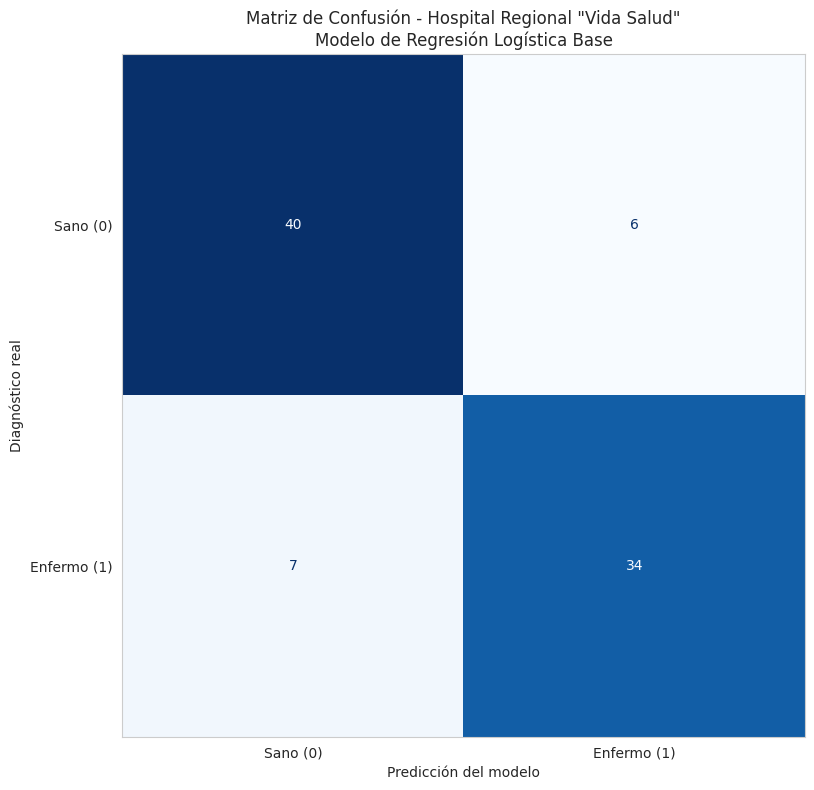

In [ ]:
matriz_confusion(yc_pred_Base, txt = "Base")

#### Modelo AIC

In [ ]:
log_reg_AIC = modelar_GS_reg_log(X_train_AIC, "AIC")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solv

In [ ]:
yc_pred_AIC, yc_proba_AIC, result_AIC = metricas_reg_log(log_reg_AIC, X_test_AIC, "AIC")

=== MÉTRICAS FINALES  DE AIC ===
Accuracy : 0.862
Precision: 0.872
Recall   : 0.829
F1-Score : 0.850
AUC-ROC  : 0.925


<Figure size 600x500 with 0 Axes>

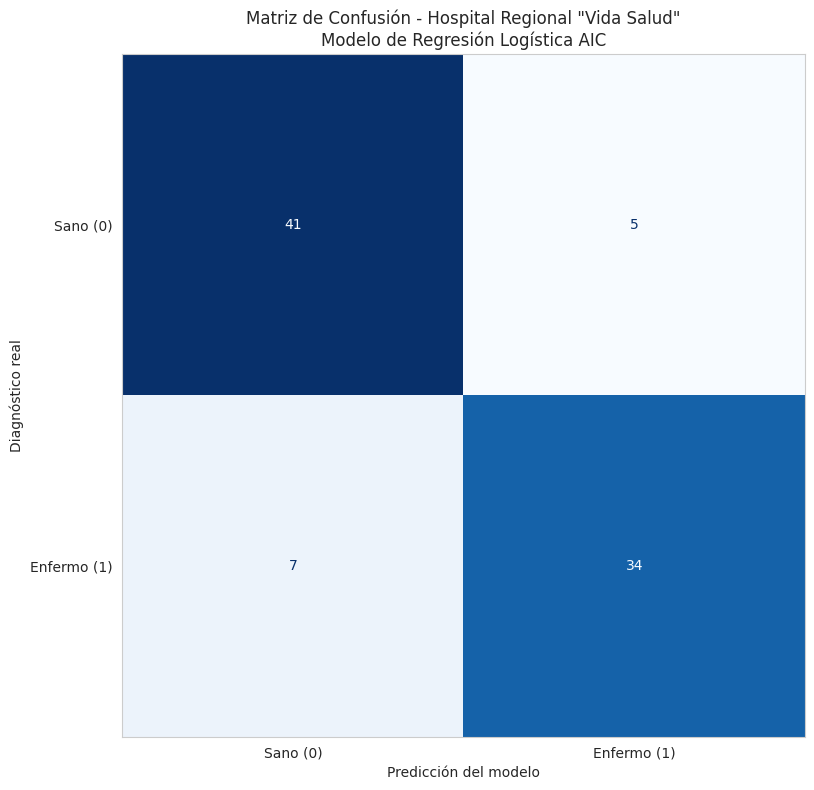

In [ ]:
matriz_confusion(yc_pred_AIC, txt = "AIC")

#### Modelo Boruta

In [ ]:
log_reg_Boruta = modelar_GS_reg_log(X_train_Boruta, "Boruta")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=200, penalty=l1, solv

In [ ]:
yc_pred_Boruta, yc_proba_Boruta, result_Boruta = metricas_reg_log(log_reg_Boruta, X_test_Boruta, "Boruta")

=== MÉTRICAS FINALES  DE Boruta ===
Accuracy : 0.839
Precision: 0.846
Recall   : 0.805
F1-Score : 0.825
AUC-ROC  : 0.909


<Figure size 600x500 with 0 Axes>

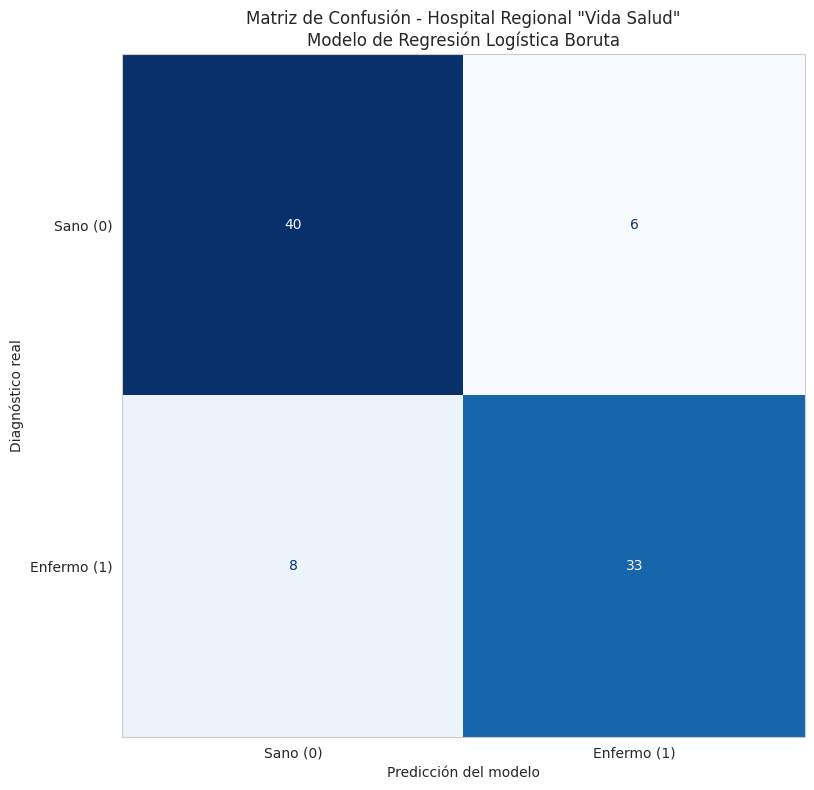

In [ ]:
matriz_confusion(yc_pred_Boruta, txt = "Boruta")

## Evaluation (Evaluación)

### Evaluar Modelos

In [ ]:
result_Base["Modelo"] = "Base"
result_AIC["Modelo"] = "AIC"
result_Boruta["Modelo"] = "Boruta"

result = pd.concat([result_Base, result_AIC, result_Boruta], ignore_index=True)
result = result.set_index("Modelo")
result.index.name = None

result.sort_values(by="AUC-ROC", ascending=False)

,Accuracy,Precision,Recall,F1-Score,AUC-ROC
AIC,0.862069,0.871795,0.829268,0.850000,0.925239
Base,0.850575,0.850000,0.829268,0.839506,0.925239
Boruta,0.839080,0.846154,0.804878,0.825000,0.909332


#### Gráfico comparativo de métricas

> Agregar bloque entrecomillado



<Figure size 1200x800 with 0 Axes>

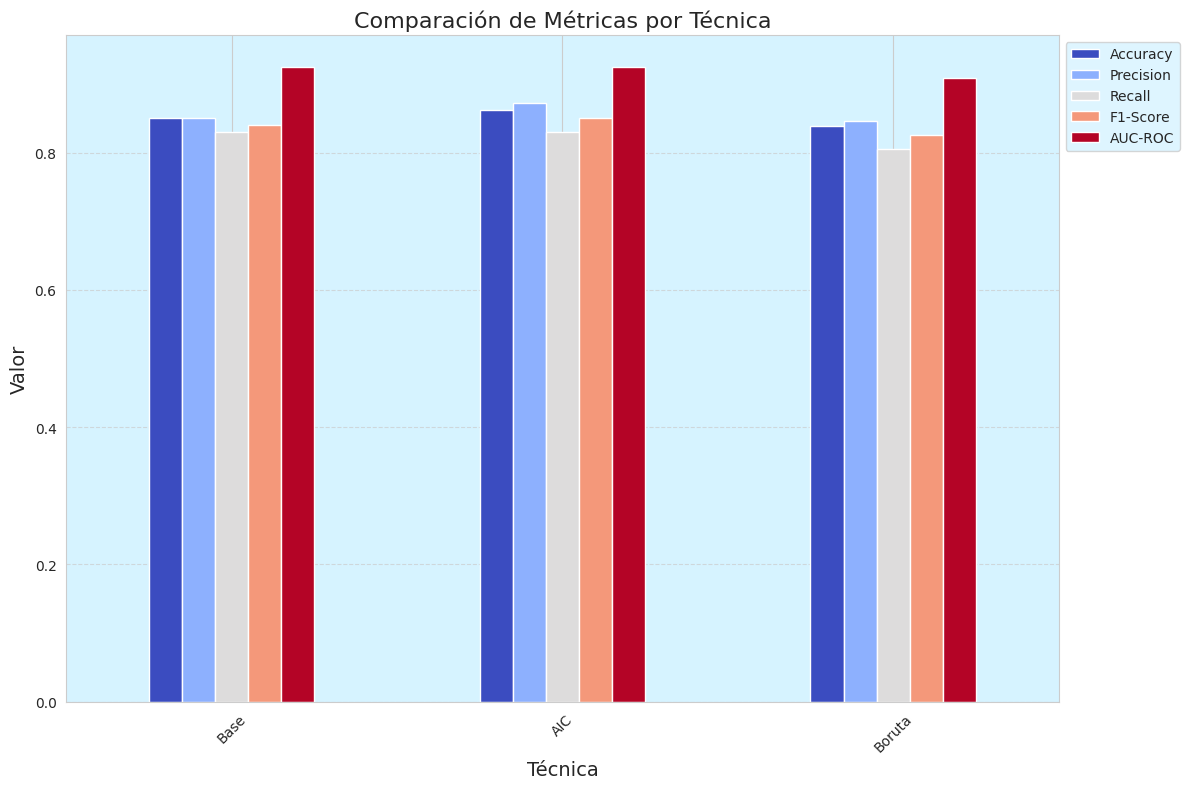

In [ ]:
# Gráfico comparativo de métricas
plt.figure(figsize=(12, 8))
result.plot(kind='bar', colormap='coolwarm', figsize=(12, 8))
plt.title("Comparación de Métricas por Técnica", fontsize=16)
plt.xlabel("Técnica", fontsize=14)
plt.ylabel("Valor", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### curva ROC

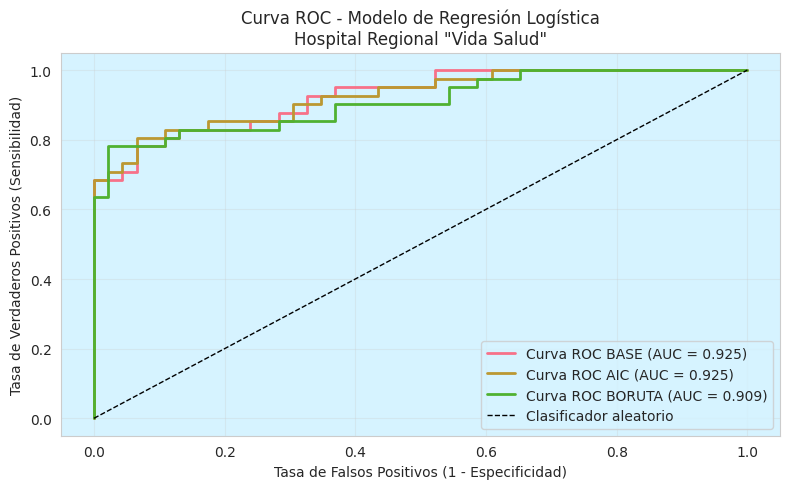

In [ ]:
# Calcular curva ROC
fpr_BASE, tpr_BASE, _ = roc_curve(yc_te, yc_proba_Base)
fpr_AIC, tpr_AIC, _ = roc_curve(yc_te, yc_proba_AIC)
fpr_BORUTA, tpr_BORUTA, _ = roc_curve(yc_te, yc_proba_Boruta)

auc_BASE = roc_auc_score(yc_te, yc_proba_Base)
auc_AIC = roc_auc_score(yc_te, yc_proba_AIC)
auc_BORUTA = roc_auc_score(yc_te, yc_proba_Boruta)

# Graficar
plt.figure(figsize=(8, 5))

plt.plot(fpr_BASE, tpr_BASE, linewidth=2, label=f'Curva ROC BASE (AUC = {auc_BASE:.3f})')
plt.plot(fpr_AIC, tpr_AIC, linewidth=2, label=f'Curva ROC AIC (AUC = {auc_AIC:.3f})')
plt.plot(fpr_BORUTA, tpr_BORUTA, linewidth=2, label=f'Curva ROC BORUTA (AUC = {auc_BORUTA:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio')


plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC - Modelo de Regresión Logística\nHospital Regional "Vida Salud"')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Validación cruzada

In [ ]:
# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Métricas personalizadas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Evaluar
scores_Base = cross_val_score(log_reg_Base, Xc_tr_sc, yc_tr, cv= cv, scoring=scoring['roc_auc'])
scores_AIC = cross_val_score(log_reg_AIC, X_train_AIC, yc_tr, cv= cv, scoring=scoring['roc_auc'])
scores_Boruta = cross_val_score(log_reg_Boruta, X_train_Boruta, yc_tr, cv= cv, scoring=scoring['roc_auc'])

print(f"✅ AUC promedio BASE (5 folds): {scores_Base.mean():.3f}")
print(f"✅ AUC promedio AIC (5 folds): {scores_AIC.mean():.3f}")
print(f"✅ AUC promedio Boruta (5 folds): {scores_Boruta.mean():.3f}")

✅ AUC promedio BASE (5 folds): 0.825
✅ AUC promedio AIC (5 folds): 0.826
✅ AUC promedio Boruta (5 folds): 0.839


#### Curvas de aprendizaje

In [ ]:
def Curva_aprendizaje(log_reg, X_train, txt = "BASE"):
  # Curva de aprendizaje
  train_sizes, train_scores, val_scores = learning_curve(
      log_reg, X_train, yc_tr,
      train_sizes=np.linspace(0.1, 1.0, 10),
      cv=5, scoring='accuracy', shuffle=True, random_state=42
  )

  # Promedios
  train_mean = train_scores.mean(axis=1)
  val_mean = val_scores.mean(axis=1)

  # Graficar
  plt.figure(figsize=(8, 5))
  plt.plot(train_sizes, train_mean, label="Entrenamiento", marker='o')
  plt.plot(train_sizes, val_mean, label="Validación", marker='s')
  plt.xlabel("Tamaño del conjunto de entrenamiento")
  plt.ylabel("Precisión")
  plt.title(f"Curva de aprendizaje - Regresión logística {txt}")
  plt.legend()
  plt.grid(True)
  plt.show()

##### Curva de Aprendizaje de Base

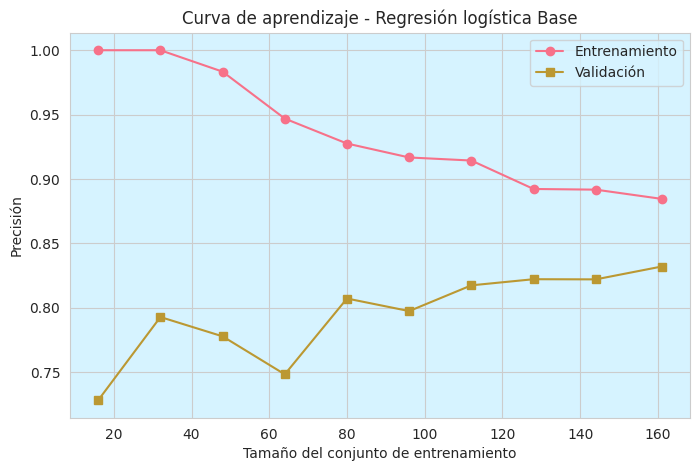

In [ ]:
Curva_aprendizaje(log_reg_Base, Xc_tr_sc, "Base")

📊 ¿Qué muestran las dos líneas?

Línea rosa ("Entrenamiento"): Precisión del modelo sobre los datos que ya conoce.

Línea mostaza ("Validación"): Precisión sobre datos nuevos (no vistos durante el entrenamiento).

🔍 Interpretación visual

🔹 Al inicio (pocos datos de entrenamiento):
Precisión de entrenamiento muy alta → el modelo memoriza fácilmente los pocos datos.

Precisión de validación más baja → no generaliza bien aún.

🔹 A medida que aumenta el tamaño del conjunto de entrenamiento:
La precisión de entrenamiento baja → el modelo ya no puede memorizar todo.

La precisión de validación se estabiliza → el modelo empieza a generalizar mejor.

##### Curva de Aprendizaje de AIC

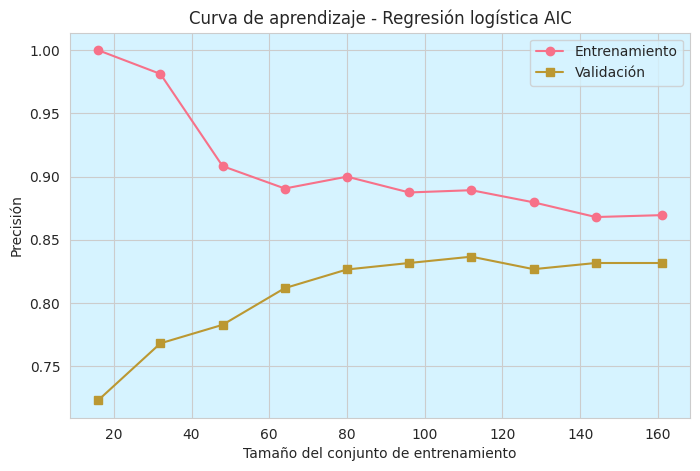

In [ ]:
Curva_aprendizaje(log_reg_AIC, X_train_AIC, "AIC")

📊 ¿Qué muestra esta curva?

Línea rosa (Entrenamiento): comienza alta y desciende suavemente conforme se agregan más datos.

Línea mostaza (Validación): comienza más baja, sube hasta un pico alrededor de 100 muestras, y luego cae ligeramente.

🔍 ¿Qué significa esta forma?

🔹 Fase inicial (hasta ~75 muestras)
El modelo mejora su generalización: la precisión de validación sube.

Esto indica que el modelo está aprendiendo patrones útiles y no está sobreajustado.

🔹 Pico de validación (~100 muestras)
Aquí el modelo alcanza su máxima capacidad de generalización con los datos disponibles.

Es un punto óptimo de aprendizaje.

🔹 Descenso leve en validación (>100 muestras)
Puede indicar que el modelo empieza a sobreadaptarse o que los nuevos datos introducen ruido.

También puede deberse a que el modelo necesita ajuste de hiperparámetros para mantener el rendimiento con más datos.

##### Curva de Aprendizaje de Boruta

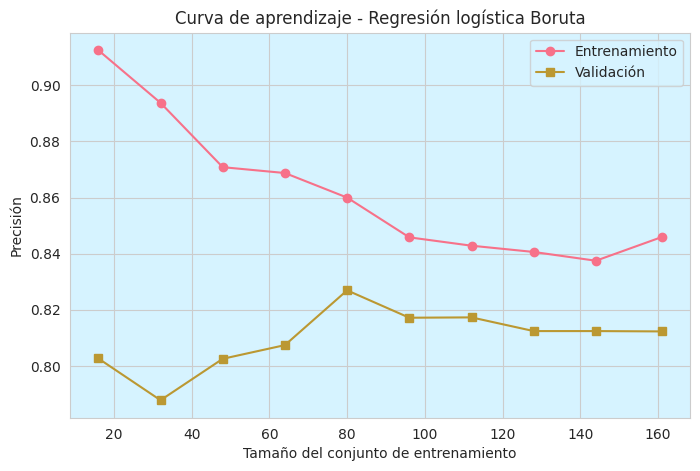

In [ ]:
Curva_aprendizaje(log_reg_Boruta, X_train_Boruta, "Boruta")

📊 ¿Qué muestra esta curva?

Línea rosa (Entrenamiento): comienza alta y baja suavemente, lo cual es normal. Indica que el modelo deja de memorizar y empieza a generalizar.

Línea marrón (Validación): se mantiene bastante estable entre 0.78 y 0.83, lo que sugiere que el modelo tiene un rendimiento consistente en datos no vistos.

✅ ¿Qué indica esta forma?

🔹 No hay underfitting
La precisión de validación no es baja ni plana.

El modelo sí está aprendiendo patrones útiles.

🔹 No hay overfitting severo
Aunque hay una pequeña brecha entre entrenamiento y validación, no es extrema.

El modelo no está memorizando, sino generalizando razonablemente bien.

🔹 Buen punto de equilibrio
A partir de ~100 muestras, ambas curvas se estabilizan.

Esto sugiere que el modelo ya no mejora mucho con más datos, pero tampoco se degrada.

### Interpretar el modelo

Interpretamos el mejor modelo (Boruta)

In [ ]:
# 1. Métricas generales
print("=== MÉTRICAS FINALES ===")
print(f"Accuracy : {accuracy_score(yc_te, yc_pred_Boruta):.3f}")
print(f"Precision: {precision_score(yc_te, yc_pred_Boruta):.3f}")
print(f"Recall   : {recall_score(yc_te, yc_pred_Boruta):.3f}")
print(f"F1-Score : {f1_score(yc_te, yc_pred_Boruta):.3f}")
print(f"AUC-ROC  : {roc_auc_score(yc_te, yc_proba_Boruta):.3f}")

# 2. Reporte detallado por clase
print("\n=== REPORTE POR CLASE ===")
print(classification_report(yc_te, yc_pred_Boruta, target_names=['Sano', 'Enfermo']))

# 3. Odds Ratios (interpretables clínicamente)
coef = pd.Series(log_reg_Boruta.coef_[0], index=X_train_Boruta.columns)
odds_ratios = np.exp(coef)
odds_df = pd.DataFrame({
    'Variable': coef.index,
    'Coeficiente': coef.values,
    'Odds Ratio': odds_ratios.values,
    'Interpretación': [f'Aumenta riesgo ({or_val:.2f}x)' if or_val > 1 else f'Reduce riesgo ({or_val:.2f}x)' for or_val in odds_ratios.values]
})

print(odds_df.round(3))

=== MÉTRICAS FINALES ===
Accuracy : 0.839
Precision: 0.846
Recall   : 0.805
F1-Score : 0.825
AUC-ROC  : 0.909

=== REPORTE POR CLASE ===
              precision    recall  f1-score   support

        Sano       0.83      0.87      0.85        46
     Enfermo       0.85      0.80      0.82        41

    accuracy                           0.84        87
   macro avg       0.84      0.84      0.84        87
weighted avg       0.84      0.84      0.84        87

                             Variable  Coeficiente  Odds Ratio  \
0                                edad        0.076       1.079   
1                          colesterol        0.079       1.082   
2             frecuencia_cardiaca_max       -0.164       0.849   
3                    angina_ejercicio        0.218       1.244   
4                        depresion_ST        0.194       1.214   
5                    vasos_coloreados        0.204       1.226   
6  tipo_dolor_pecho_dolor no anginoso        0.231       1.259   
7       

#### Feature importance

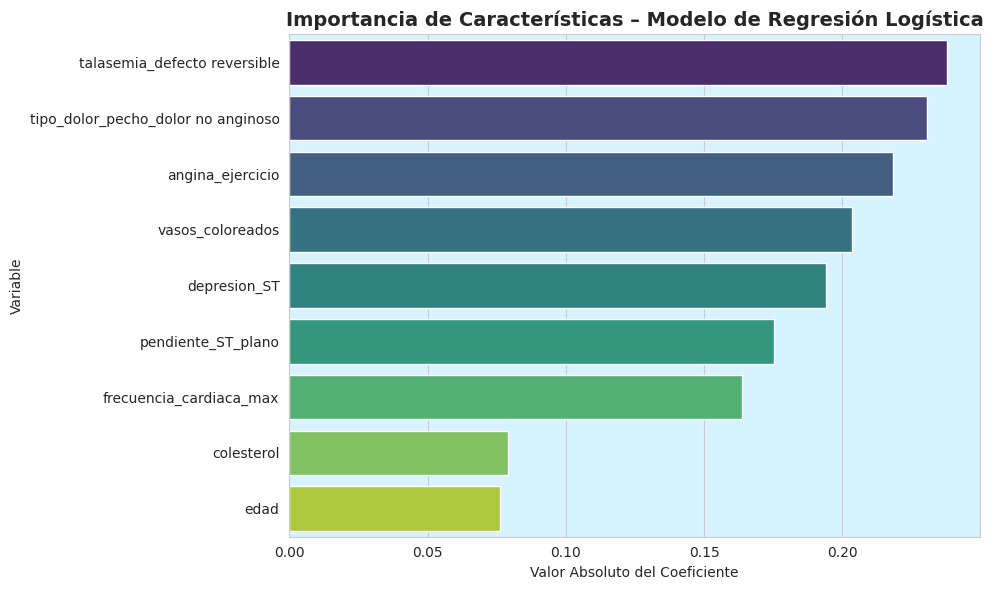


📊 Coeficientes ordenados por importancia:


,Variable,Coeficiente,Importancia_Absoluta
8,talasemia_defecto reversible,0.237827,0.237827
6,tipo_dolor_pecho_dolor no anginoso,0.230599,0.230599
3,angina_ejercicio,0.218152,0.218152
5,vasos_coloreados,0.203570,0.203570
4,depresion_ST,0.194079,0.194079
7,pendiente_ST_plano,0.175319,0.175319
2,frecuencia_cardiaca_max,-0.163716,0.163716
1,colesterol,0.079086,0.079086
0,edad,0.076055,0.076055


In [ ]:
# Crear un DataFrame con las variables y sus coeficientes
# Usamos el modelo final (por ejemplo, glm_smote o glm_no_balanceo)
feature_importance = pd.DataFrame({
    'Variable': X_train_Boruta.columns,
    'Coeficiente': log_reg_Boruta.coef_[0]
})

# Agregar una columna con el valor absoluto del coeficiente para medir la magnitud
feature_importance['Importancia_Absoluta'] = np.abs(feature_importance['Coeficiente'])

# Ordenar las variables por importancia descendente
feature_importance = feature_importance.sort_values(by='Importancia_Absoluta', ascending=False)

# Visualizar las 15 variables más importantes (puedes ajustar el número)
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importancia_Absoluta',
    y='Variable',
    data=feature_importance.head(15),
    palette='viridis'
)
plt.title("Importancia de Características – Modelo de Regresión Logística", fontsize=14, fontweight='bold')
plt.xlabel("Valor Absoluto del Coeficiente")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Mostrar tabla con los coeficientes ordenados
print("\n📊 Coeficientes ordenados por importancia:")
display(feature_importance.head(15))


#### INTERPRETACIÓN DE COEFICIENTES


🔬 FASE 4.2: INTERPRETACIÓN DE COEFICIENTES
Los coeficientes indican el cambio en el log-odds por unidad de cambio en X
El Odds Ratio (OR) transforma ese cambio en una medida más interpretable
                             Variable  Coeficiente  Odds_Ratio  Abs_Coef
8        talasemia_defecto reversible     0.237827    1.268490  0.237827
6  tipo_dolor_pecho_dolor no anginoso     0.230599    1.259355  0.230599
3                    angina_ejercicio     0.218152    1.243776  0.218152
5                    vasos_coloreados     0.203570    1.225772  0.203570
4                        depresion_ST     0.194079    1.214192  0.194079
7                  pendiente_ST_plano     0.175319    1.191626  0.175319
2             frecuencia_cardiaca_max    -0.163716    0.848983  0.163716
1                          colesterol     0.079086    1.082297  0.079086
0                                edad     0.076055    1.079022  0.076055

TOP 10 VARIABLES MÁS INFLUYENTES EN EL MODELO:
  • talasemia_defecto reversi

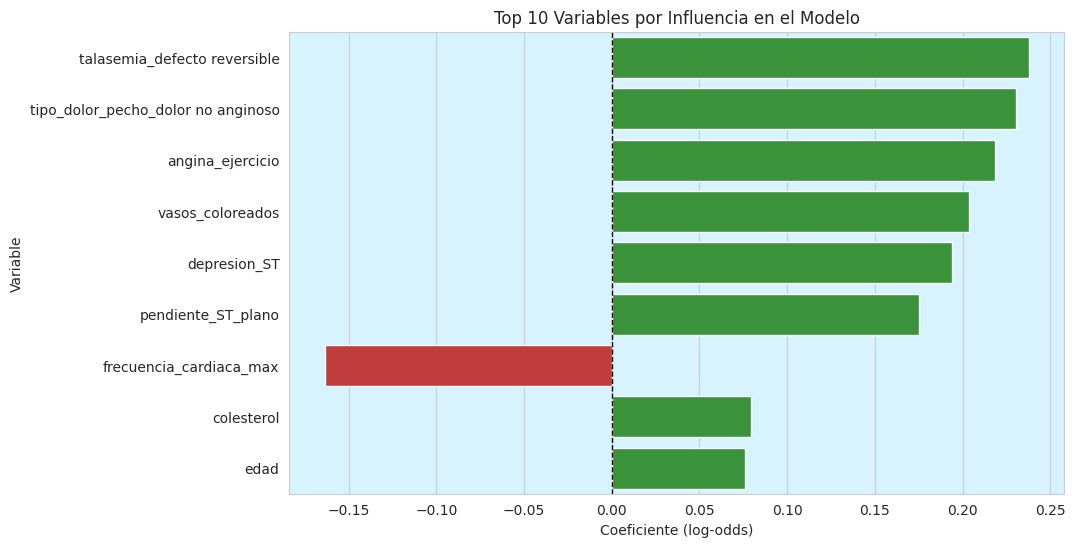

In [ ]:
print("\n🔬 FASE 4.2: INTERPRETACIÓN DE COEFICIENTES")
print("Los coeficientes indican el cambio en el log-odds por unidad de cambio en X")
print("El Odds Ratio (OR) transforma ese cambio en una medida más interpretable")

# Construir dataframe con coeficientes
coef_df = pd.DataFrame({
    'Variable': X_train_Boruta.columns,
    'Coeficiente': log_reg_Boruta.coef_[0],#extare los coeficientes
    'Odds_Ratio': np.exp(log_reg_Boruta.coef_[0]),#convierte los coeficientes en OR
    'Abs_Coef': np.abs(log_reg_Boruta.coef_[0])# CALCULA el valor absoluto de cada coeficie
})

# Ordenar por magnitud
coef_top = coef_df.sort_values('Abs_Coef', ascending=False).head(10)
print(coef_top) # opcional

print("\nTOP 10 VARIABLES MÁS INFLUYENTES EN EL MODELO:")
#for _, ignora esto
for _, row in coef_top.iterrows():
    var = row['Variable']
    coef = row['Coeficiente']
    odds = row['Odds_Ratio']
    direction = "aumenta" if coef > 0 else "disminuye"
        #SI EL COEF>0 UN AUMENTO EN LA VARIABLE AUMENTA las odds de que sea benigno (1)
        # Si el coef <0 un aumento en la variable disminuye las odds de que sea benigno (1)
        #la clase positiva =1 que sea benigno
        #OR=0.3

    print(f"  • {var:25s}:")
    print(f"      - Coeficiente (log-odds): {coef:.3f}")
    print(f"      - Odds Ratio (OR): {odds:.3f}")
    print(f"      - Interpretación: un aumento unitario en esta variable {direction} "
          f"las odds de que el tumor sea benigno en un factor de {odds:.2f}x")

# Gráfico de barras con los coeficientes más influyentes
plt.figure(figsize=(10,6))
sns.barplot(x='Coeficiente', y='Variable', data=coef_top,
            palette=['#d62728' if c<0 else '#2ca02c' for c in coef_top['Coeficiente']])
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title("Top 10 Variables por Influencia en el Modelo")
plt.xlabel("Coeficiente (log-odds)")
plt.ylabel("Variable")
plt.show()

#### SHAP values


=== PREDICCIÓN #1 ===


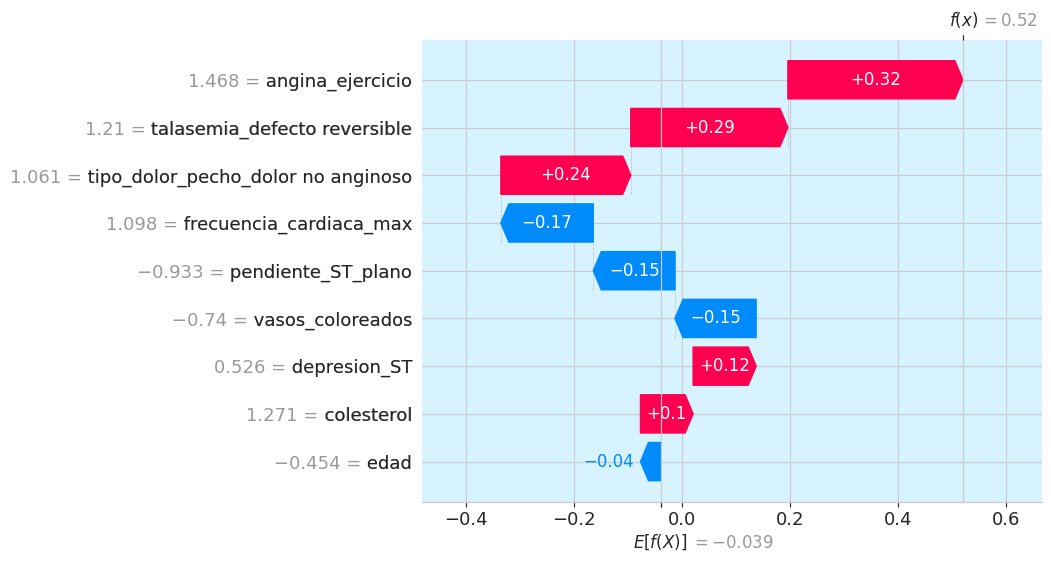


=== PREDICCIÓN #2 ===


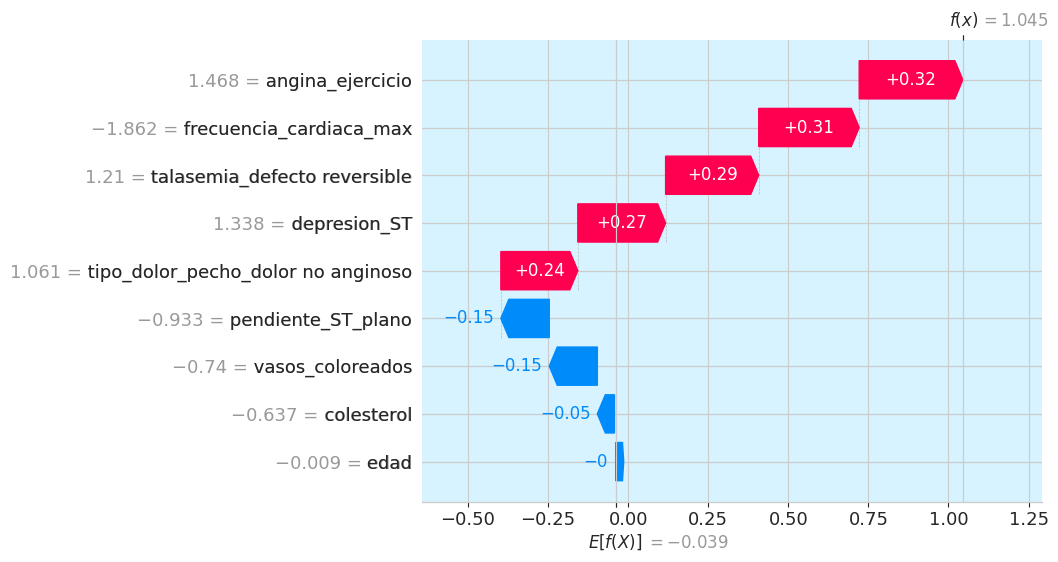


=== PREDICCIÓN #3 ===


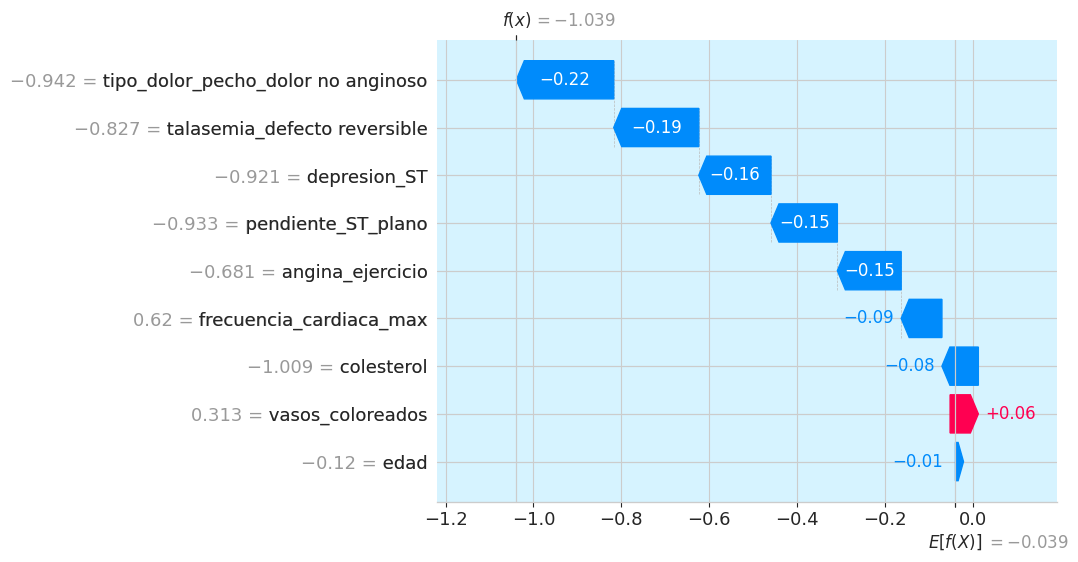


=== PREDICCIÓN #4 ===


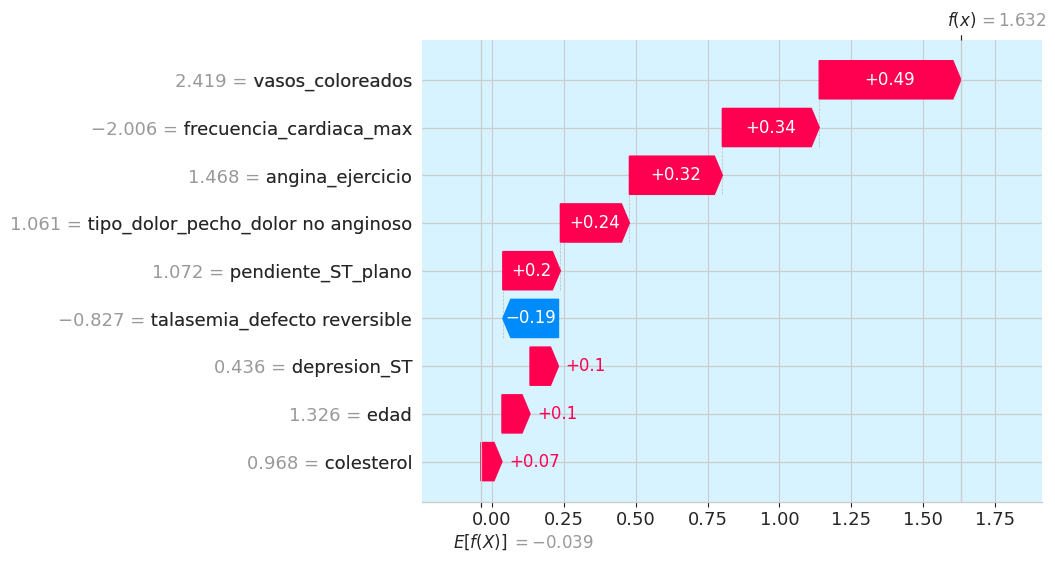


=== PREDICCIÓN #5 ===


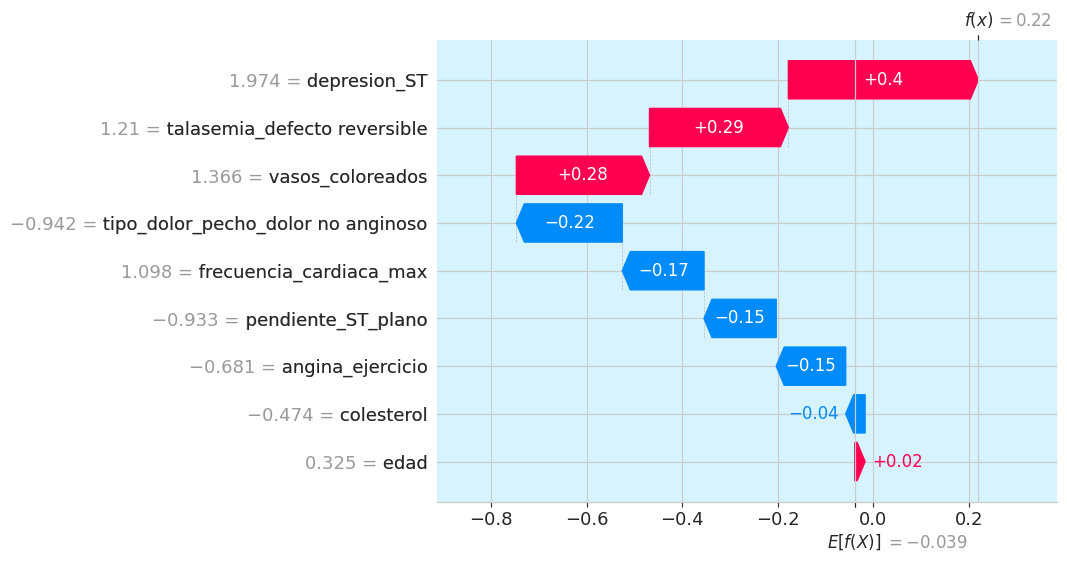


=== PREDICCIÓN #6 ===


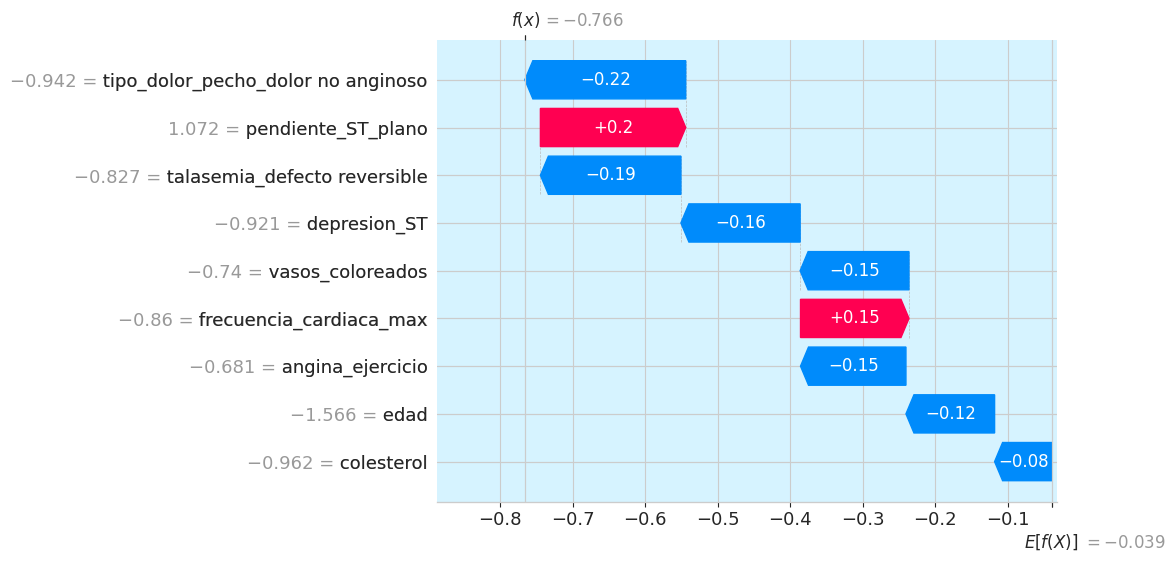


=== PREDICCIÓN #7 ===


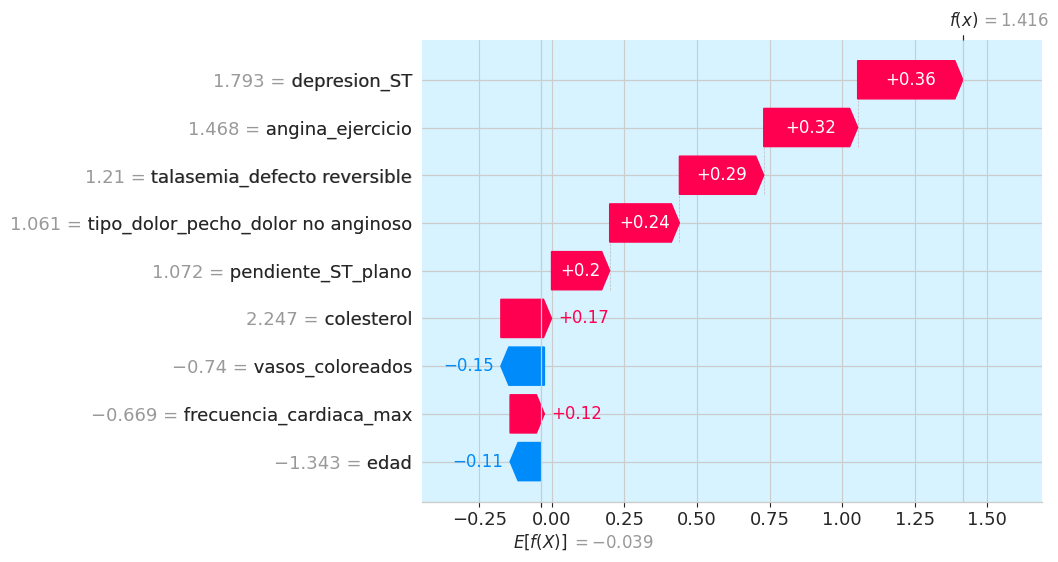


=== PREDICCIÓN #8 ===


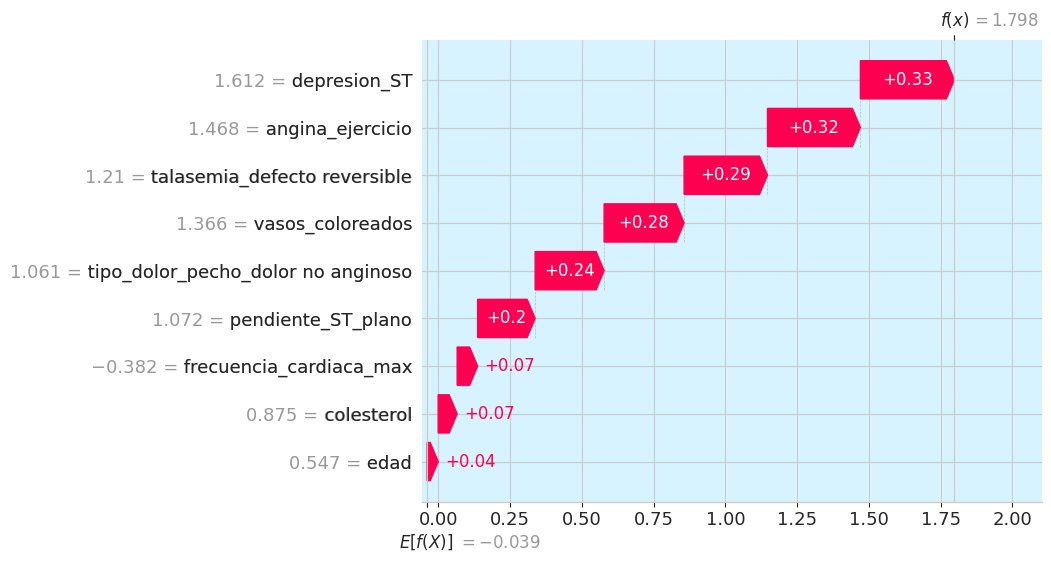


=== PREDICCIÓN #9 ===


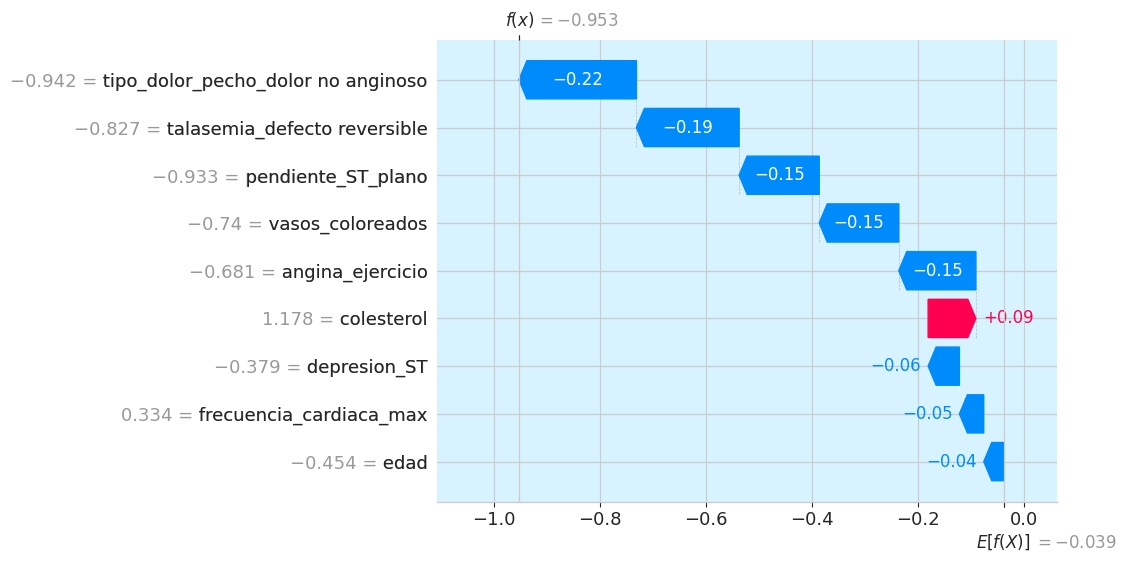


=== PREDICCIÓN #10 ===


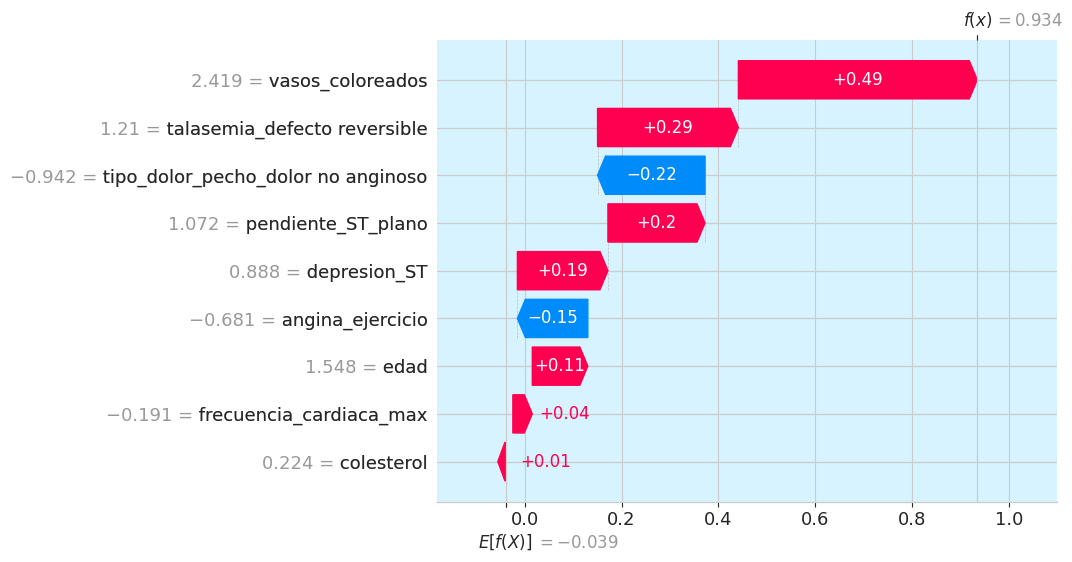

In [ ]:
explainer = shap.Explainer(log_reg_Boruta, X_train_Boruta)
shap_values = explainer(X_test_Boruta)

# Visualizar una predicción
for i in range(10):
  print(f"\n=== PREDICCIÓN #{i+1} ===")
  shap.plots.waterfall(shap_values[i])

### Reflexión crítica

Con la regresión logística aplicada sobre las variables seleccionadas por Boruta, se busca preservar la interpretabilidad clínica sin renunciar a una selección robusta de atributos.

Sin embargo, es importante reconocer que el modelo presenta ciertas limitaciones.

En primer lugar, su capacidad predictiva está acotada por la linealidad inherente a la regresión logística, lo cual podría restringir la captura de interacciones complejas entre variables fisiológicas.

Además, al haber utilizado RandomForest para la selección de variables, existe el riesgo de que el sesgo implícito en dicho algoritmo —por ejemplo, su tendencia a favorecer variables con mayor cardinalidad o menor ruido— se traslade a la etapa final, afectando la neutralidad del modelo.

Éticamente, esto exige cautela: si el modelo se implementara en un entorno clínico real, debe garantizarse que no perpetúe inequidades diagnósticas ni excluya perfiles atípicos pero clínicamente relevantes.

Finalmente, el contexto de aplicación —el Hospital Regional “Vida Salud”— demanda que cualquier herramienta predictiva sea validada no solo estadísticamente, sino también en función de su utilidad operativa y su alineación con protocolos médicos vigentes.

En ese sentido, el modelo Boruta-Regresión Logística ofrece una base sólida, pero su implementación debe ir acompañada de monitoreo continuo, revisión interdisciplinaria y apertura a ajustes conforme evolucione la evidencia clínica.

## Deployment (Implementación - Conceptual)

La estrategia de implementación propuesta para el modelo Boruta-Regresión Logística se orienta a su integración como herramienta de apoyo diagnóstico en el flujo clínico del Hospital Regional “Vida Salud”. En términos operativos, el modelo podría incorporarse en la etapa de triaje o evaluación inicial, donde el personal médico ingresa las variables clínicas relevantes en una interfaz sencilla. El sistema devolvería una probabilidad de riesgo cardiovascular, permitiendo priorizar casos críticos y optimizar la asignación de recursos. Esta integración debe ser complementaria, nunca sustitutiva, del juicio médico, y su uso debe estar respaldado por protocolos institucionales.

Respecto al plan de monitoreo, se recomienda vigilar métricas clave como la precisión, el recall y el AUC-ROC en datos reales, además del número de falsos positivos y negativos registrados mensualmente. Esto permitirá detectar desviaciones en el rendimiento del modelo y evaluar su impacto clínico. Asimismo, se sugiere implementar un sistema de retroalimentación donde los médicos puedan reportar casos en los que el modelo haya fallado, lo cual enriquecería el proceso de mejora continua.

El protocolo de actualización debe considerar un reentrenamiento trimestral o semestral, dependiendo del volumen de nuevos datos clínicos disponibles. En contextos de alta variabilidad epidemiológica, como brotes o cambios en la población atendida, este intervalo podría acortarse. Es fundamental que cada actualización sea precedida por una validación interna y una revisión ética, asegurando que el modelo no incorpore sesgos ni pierda interpretabilidad.

Como recomendaciones accionables, se propone capacitar al personal médico en la lectura de probabilidades y en la interpretación de variables explicativas, especialmente aquellas con alto peso en la predicción. También se sugiere establecer un comité técnico-clínico que supervise el uso del modelo y evalúe su pertinencia en distintos servicios del hospital. Finalmente, el roadmap de mejora continua debe incluir la exploración de modelos híbridos, la incorporación de nuevas variables clínicas conforme evolucione la evidencia, y la evaluación periódica del impacto del modelo en la toma de decisiones médicas y en los resultados de salud de los pacientes.

In [ ]:
!jupyter nbconvert --to html GAD_Heart_Disease_Prediction.ipynb

[NbConvertApp] WARNING | pattern 'GAD_Heart_Disease_Prediction.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=Tr